In [1]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn import metrics
print(torch.cuda.is_available())
from torch.utils.data import DataLoader
# import pytorch_lightning as pl
from vis_model import ReconstructionModel,SegmentationModel,BaseModel
from utils import *
from predict import model_predict, sr_predict_lung_segmentation, sr_predict_lung_segmentation_spot
from dataset import ViT_HER2ST, ViT_SKIN,HER2ST,LUNG,LUNG_seg,LUNG_single_large,LUNG_single
from PIL import Image
import glob
# from pytorch_lightning import LightningModule
# from pytorch_lightning.callbacks import ModelCheckpoint
from scipy import stats
import scanpy as sc
import cv2
import torch.nn.functional as F
from skimage.segmentation import watershed
os.environ["TORCH_CPP_LOG_LEVEL"]="INFO"
os.environ["TORCH_DISTRIBUTED_DEBUG"] = "DETAIL"
# Check if CUDA is available
print(torch.cuda.is_available())
from histolab.filters.image_filters import RgbToHed, HematoxylinChannel
from scipy import ndimage as ndi
from skimage.measure import regionprops
from skimage.morphology import h_maxima
from scipy.spatial import KDTree
from scipy import ndimage
from skimage.measure import regionprops
from hipt_model_utils import eval_transforms

/ihome/wchen/chz113/miniconda3/envs/segmentation/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


True


/ihome/wchen/chz113/miniconda3/envs/segmentation/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True


In [3]:
image_array = np.array(image_rgb)
np.save('/ix1/wchen/Zhaochongyue/spatial/visium_06.npy', image_array)
labels_npz_path = '/ix1/wchen/Zhaochongyue/spatial/visium_06.npz'
labels=stardist(image_array, labels_npz_path,prob_thresh=0.4,nms_thresh=0.5)

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.
effective: block_size=(8192, 8192, 3), min_overlap=(128, 128, 0), context=(128, 128, 0)


2024-09-07 15:05:09.581343: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
100%|██████████| 6/6 [01:57<00:00, 19.55s/it]


Found 112530 objects


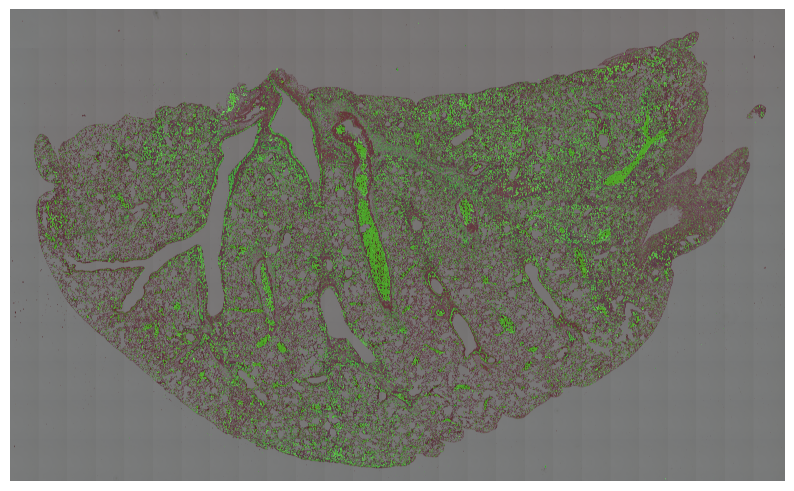

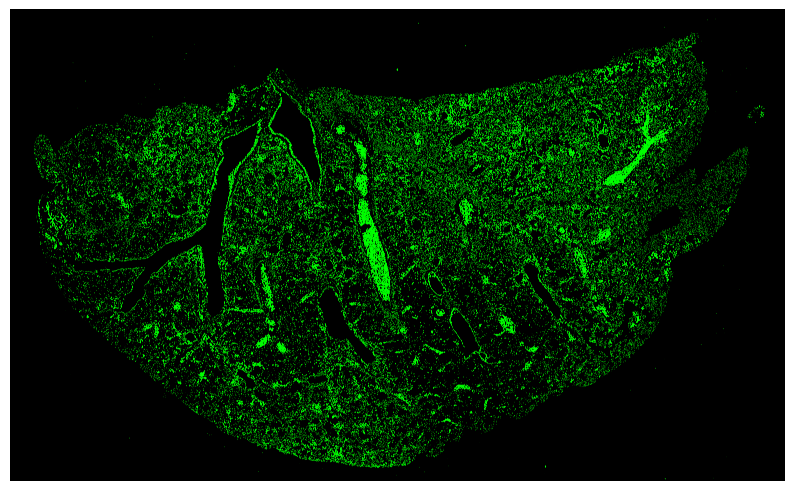

In [3]:
import tifffile as tiff
import scipy
labels_npz_path = '/ix1/wchen/Zhaochongyue/spatial/visium_06.npz'
# Load the saved npz file
cell_data = scipy.sparse.load_npz(labels_npz_path)
labels = cell_data.toarray()
def get_img(name):
    if name in ['A1', 'A2', 'A3','A4']:
        img_fold = os.path.join('/ix1/wchen/Zhaochongyue/spatial/Lung/ST/', name,
                                'outs/spatial/full_image.tif')
    elif name=='08_WT_F_S':
        name='08_WT_F-S'
        img_fold = os.path.join('/ix1/wchen/Shiyue/Projects/2023_06_Influ_Mouse_Lung_ST/RawData/Fastq/Alcorn_Visium_FFPE_Images/', name + '.TIF')
    elif name=='09_WT_F_S':
        name='09_WT_F-S'
        img_fold = os.path.join('/ix1/wchen/Shiyue/Projects/2023_06_Influ_Mouse_Lung_ST/RawData/Fastq/Alcorn_Visium_FFPE_Images/', name + '.TIF')
    else:
        img_fold = os.path.join('/ix1/wchen/Shiyue/Projects/2023_06_Influ_Mouse_Lung_ST/RawData/Fastq/Alcorn_Visium_FFPE_Images/', name + '.TIF')
    img_color = cv2.imread(img_fold, cv2.IMREAD_COLOR)
    # print(img_color.shape,'shape')
    img_color = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    # img_color = img_color.astype(np.float32) / 255.0
    # img_color = eval_transforms()(img_color)
    # img_color=img_color.permute(1, 2, 0)
    #print(img_color.shape,'shape1')
    return img_color
names = ['06_WT_Flu_Only']
# print(names[0])
image_rgb = get_img(names[0])
image_array = np.array(image_rgb)
def overlay_labels_on_image(image, labels):
    # Ensure the image is in uint8 format
    if image.dtype != np.uint8:
        image_rgb = (255 * (image - image.min()) / (image.max() - image.min())).astype(np.uint8)
    else:
        image_rgb = image.copy()

    # Create an RGB image if the input image is grayscale
    if len(image_rgb.shape) == 2 or image_rgb.shape[2] == 1:
        image_rgb = cv2.cvtColor(image_rgb, cv2.COLOR_GRAY2RGB)

    # Define green color for the masks
    green_color = np.array([0, 255, 0], dtype=np.uint8)

    # Create a mask where the labels are not zero
    mask = labels > 0

    # Apply the green color to the mask regions using vectorized operations
    overlay = np.zeros_like(image_rgb, dtype=np.uint8)
    overlay[mask] = green_color

    # Blend the original image with the color overlay
    alpha = 0.5  # Transparency factor
    blended = cv2.addWeighted(image_rgb, 1 - alpha, overlay, alpha, 0)

    return blended

# Example usage:
blended_image = overlay_labels_on_image(image_array, labels)

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(blended_image)
plt.axis('off')
plt.show()
def plot_masks_only(labels):
    # Create an RGB image with a black background
    mask_rgb = np.zeros((labels.shape[0], labels.shape[1], 3), dtype=np.uint8)

    # Define green color for the masks
    green_color = [0, 255, 0]

    # Apply the green color to the mask regions using vectorized operations
    mask_rgb[labels > 0] = green_color

    return mask_rgb

# Example usage:
mask_image = plot_masks_only(labels)

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(mask_image)
plt.axis('off')
plt.show()


In [5]:
num_gpus = torch.cuda.device_count()
for i in range(num_gpus):
    torch.cuda.set_device(i)
    torch.cuda.empty_cache()
#import torch.nn as nn

class Net(nn.Module):
    def __init__(self, num_features):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(num_features, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(0.25)  # Dropout layer with 25% dropout rate

        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.dropout2 = nn.Dropout(0.25)  # Dropout layer with 25% dropout rate

        self.fc3 = nn.Linear(32, 1)

    def forward(self, x, round_output=False):
        x = self.fc1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.dropout2(x)

        x = self.fc3(x)  # No activation function for regression

        if round_output:
            x = torch.round(x)  # Round to nearest integer

        return x


def reconstruct_label_image1(patches, centers, labels, gene_map, original_shape):
    """
    Reconstruct label image from patches for a single batch using clustering.

    Parameters:
        patches (np.array): The image patches of shape (num_patches, patch_height, patch_width).
        centers (np.array): The (x, y) coordinates of the center of each patch in the original image of shape (num_patches, 2).
        labels (np.array): The predicted label for the center of each patch of shape (num_patches, num_classes).
        gene_map (np.array): The gene map features for each patch of shape (num_patches, feature_height, feature_width, feature_depth).
        original_shape (tuple): The shape of the original image (H, W, C).

    Returns:
        label_image_cluster (np.array): The reconstructed label image with clustering of shape (H, W).
    """
    print(patches.shape, labels.shape, gene_map.shape, centers.shape,original_shape)
    num_patches, patch_h, patch_w, _ = patches.shape
    H, W, _ = original_shape[0].item(), original_shape[1].item(), original_shape[2].item()

    # Initialize an array to store the final label image with clustering
    label_image_cluster = np.zeros((H, W), dtype=np.uint8)

    label_lists_cluster = [[[] for _ in range(W)] for _ in range(H)]

    for p in range(num_patches):
        center_x, center_y = centers[p]
        #print(center_x,center_y,"center")
        top_left_x = int(center_x - patch_w // 2)
        top_left_y = int(center_y - patch_h // 2)

        patch_features = gene_map[p]
        patch_features_flat = patch_features.reshape(-1, patch_features.shape[0])  # Shape: (112*112, 64)

        # Perform clustering on the flattened patch features
        kmeans = KMeans(n_clusters=2, random_state=0).fit(patch_features_flat)
        cluster_labels = kmeans.labels_.reshape(patch_h, patch_w)

        # Perform clustering on the patch features
        #kmeans = KMeans(n_clusters=2, random_state=0).fit(patch_features.reshape(-1, patch_features.shape[-1]))
        #cluster_labels = kmeans.labels_.reshape(patch_h, patch_w)

        for i in range(patch_h):
            for j in range(patch_w):
                x = top_left_x + j
                y = top_left_y + i

                if 0 <= x < W and 0 <= y < H:
                    # Directly assign the label from cluster_labels to the label_image_cluster array
                    label_image_cluster[y, x] = cluster_labels[i, j]
    # Create an image to store the final label of each pixel
    #for i in range(H):
    #    for j in range(W):
    #        #print(label_lists_cluster[i][j])
    #        if label_lists_cluster[i][j]:
    #            if len(label_lists_cluster[i][j]) > 1:
    #                label_image_cluster[i, j] = stats.mode(label_lists_cluster[i][j])[0][0]
    #            else:
    #                label_image_cluster[i, j] = label_lists_cluster[i][j][0]
    #        else:
    #            label_image_cluster[i, j] = 0

    return label_image_cluster


#from pytorch_lightning.plugins import DDPPlugin
def reconstruct_label_image(patches, centers, labels, gene_map,original_shape):
    """
    Reconstruct label image from patches.

    Parameters:
        patches (np.array): The image patches of shape (batch_size, num_patches, feature_size).
        centers (np.array): The (x, y) coordinates of the center of each patch in the original image of shape (batch_size, num_patches, 2).
        labels (np.array): The predicted label for the center of each patch of shape (batch_size, num_patches, num_classes).
        original_shape (np.array): The shape of the original image (batch_size, H, W, C).

    Returns:
        label_images (np.array): The reconstructed label images of shape (batch_size, H, W).
    """
    print(patches.shape,labels.shape,gene_map.shape,centers.shape)
    num_patches, _,_,_= patches.shape
    _, num_classes = labels.shape
    H, W, _ = original_shape
    
    # Initialize an array to store the final label images for each batch
    label_images = np.zeros((batch_size, H, W), dtype=np.uint8)
    label_images_cluster = np.zeros((batch_size, H, W), dtype=np.uint8)
    for b in range(batch_size):
        label_lists = [[[] for _ in range(W)] for _ in range(H)]  # To store labels of each pixel
        label_lists_cluster = [[[] for _ in range(W)] for _ in range(H)]
        for p in range(num_patches):
            center_x, center_y = centers[b, p]
            # Assuming patch size is known, otherwise, it needs to be passed as a parameter
            patch_h, patch_w = 112, 112 
            top_left_x = int(center_x - patch_w // 2)
            top_left_y = int(center_y - patch_h // 2)
            
            # Get the predicted label for the patch
            label = np.argmax(labels[b, p, :])
            patch_features =gene_map[b, p].reshape(patch_h, patch_w, -1)
            
            # Perform clustering on the patch features
            kmeans = KMeans(n_clusters=2, random_state=0).fit(patch_features.reshape(-1, patch_features.shape[-1]))
            cluster_labels = kmeans.labels_.reshape(patch_h, patch_w)
            for i in range(patch_h):
                for j in range(patch_w):
                    x = top_left_x + j
                    y = top_left_y + i
                    
                    if 0 <= x < W and 0 <= y < H:
                        label_lists[y][x].append(label)
                        label_lists_cluster[y][x].append(cluster_labels)
        # Create an image to store the final label of each pixel
        for i in range(H):
            for j in range(W):
                if label_lists[i][j]:
                    label_images[b, i, j] = stats.mode(label_lists[i][j])[0][0]
                    label_images_cluster[b, i, j] = stats.mode(label_lists_cluster[i][j])[0][0]
                else:
                    label_images[b, i, j] = 0
                    label_images_cluster[b, i, j] = 0  # Default cluster label
    
    return label_images,label_images_cluster

def save_label_images(label_images, save_path):
    for i, img in enumerate(label_images):
        filename = f"{save_path}/label_image_{i}.png"
        im = Image.fromarray(img.astype('uint8'))
        im.save(filename)
def save_label_cluster(label_image, save_path):
    filename = f"{save_path}/label_cluster.png"
    im = Image.fromarray(label_image.astype('uint8'), 'L')  # 'L' mode for grayscale
    im.save(filename)

def train(model, train_loader, optimizer, device, criterion):
    model.train()
    total_loss = 0.0
    chunk_size = 2000
    for batch in train_loader:
        patch, target_gene, target_seg,_ = batch
        #print(patch.shape,target_gene.shape,'shape0')
        num_chunks = patch.size(1) // chunk_size
        if patch.size(1) % chunk_size != 0:
            num_chunks += 1  # Account for the last chunk
        for i in range(num_chunks):
            # Extract the chunk of the patch
            start_idx = i * chunk_size
            end_idx = start_idx + chunk_size
            patch_chunk = patch[:, start_idx:end_idx, :, :, :]
            target_gene_chunk = target_gene[:, start_idx:end_idx, :]

            # Move the chunks to the device
            patch_chunk = patch_chunk.to(device)
            target_gene_chunk = target_gene_chunk.to(device)

            # Zero the gradients for each chunk
            optimizer.zero_grad()

            # Process the chunk through the model
            _, _, loss = model(patch_chunk, target_gene_chunk)

            # Perform backpropagation and update weights
            loss.backward()
            optimizer.step()

            # Accumulate the loss
            total_loss += loss.item() / num_chunks
    return total_loss / len(train_loader)
def train_count_simple(net, train_loader, optimizer, device, criterion, all_image_embeddings, all_spot_embeddings):
    net.train()
    net = net.to(device)
    total_loss = 0.0
    all_batch_outputs = []  # Store combined outputs for each batch
    all_batch_weak_labels = []  # Store combined weak labels for each batch
    all_individual_batch_outputs = []  # Store individual outputs for each batch
    all_individual_batch_weak_labels = []  # Store individual weak labels for each batch

    for i, batch in enumerate(train_loader):
        _, target_gene, _,_= batch
        weak_labels = estimate_cell_number_RNA_reads_for_batch(target_gene, 5)
        y = torch.tensor(weak_labels, dtype=torch.float32).to(device)

        optimizer.zero_grad()
        image_embeddings = all_image_embeddings[i].to(device)
        #print(all_image_embeddings[i].shape)
        spot_embeddings = all_spot_embeddings[i].to(device)
        combined_embeddings = torch.cat([image_embeddings, spot_embeddings], dim=-1)

        outputs = net(combined_embeddings)
        loss = criterion(outputs, y.view(-1, 1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Store outputs and weak labels for the current batch
        all_individual_batch_outputs.append(outputs.detach().cpu())
        all_individual_batch_weak_labels.append(y.cpu())

        # Combine outputs and weak labels for the current batch
        combined_batch_outputs = torch.cat(all_individual_batch_outputs, dim=0)
        combined_batch_weak_labels = torch.cat(all_individual_batch_weak_labels, dim=0)
        all_batch_outputs.append(combined_batch_outputs)
        all_batch_weak_labels.append(combined_batch_weak_labels)

        # Reset for the next batch
        all_individual_batch_outputs = []
        all_individual_batch_weak_labels = []

    return total_loss / len(train_loader), all_batch_outputs, all_batch_weak_labels
def train_count_seg(net, train_loader, optimizer, device, criterion, all_image_embeddings, all_spot_embeddings,weak_counts):
    net.train()
    net = net.to(device)
    total_loss = 0.0
    all_batch_outputs = []  # Store combined outputs for each batch
    all_batch_weak_labels = []  # Store combined weak labels for each batch
    all_individual_batch_outputs = []  # Store individual outputs for each batch
    all_individual_batch_weak_labels = []  # Store individual weak labels for each batch

    for i, batch in enumerate(train_loader):
        _, target_gene, _ ,_= batch
        weak_labels = weak_counts[i]
        y = torch.tensor(weak_labels, dtype=torch.float32).to(device)

        optimizer.zero_grad()
        image_embeddings = all_image_embeddings[i].to(device)
        #print(all_image_embeddings[i].shape)
        spot_embeddings = all_spot_embeddings[i].to(device)
        combined_embeddings = torch.cat([image_embeddings, spot_embeddings], dim=-1)

        outputs = net(combined_embeddings)
        loss = criterion(outputs, y.view(-1, 1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Store outputs and weak labels for the current batch
        all_individual_batch_outputs.append(outputs.detach().cpu())
        all_individual_batch_weak_labels.append(y.cpu())

        # Combine outputs and weak labels for the current batch
        combined_batch_outputs = torch.cat(all_individual_batch_outputs, dim=0)
        combined_batch_weak_labels = torch.cat(all_individual_batch_weak_labels, dim=0)
        all_batch_outputs.append(combined_batch_outputs)
        all_batch_weak_labels.append(combined_batch_weak_labels)

        # Reset for the next batch
        all_individual_batch_outputs = []
        all_individual_batch_weak_labels = []

    return total_loss / len(train_loader), all_batch_outputs, all_batch_weak_labels
def train_count_seg_cluster(net, train_loader, optimizer, device, criterion, all_image_embeddings, all_spot_embeddings, weak_counts, n_clusters=4):
    net.train()
    net = net.to(device)
    total_loss = 0.0
    all_batch_outputs = []
    all_batch_weak_labels = []

    for i, batch in enumerate(train_loader):
        _, target_gene, _,_ = batch
        target_gene_np = target_gene.view(-1, target_gene.size(-1)).numpy()   # Assuming target_gene is a tensor

        # Cluster target_gene into n_clusters
        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(target_gene_np)
        cluster_labels = kmeans.labels_
        numeric_weak_counts = [float(count) for count in weak_counts[i]]
        for cluster in range(n_clusters):
            # Select data corresponding to the current cluster
            cluster_indices = (cluster_labels == cluster)
            cluster_embeddings = torch.cat([all_image_embeddings[i][cluster_indices], all_spot_embeddings[i][cluster_indices]], dim=-1).to(device)
            cluster_weak_labels = torch.tensor([numeric_weak_counts[j] for j in range(len(cluster_indices)) if cluster_indices[j]], dtype=torch.float32).to(device)

            optimizer.zero_grad()
            outputs = net(cluster_embeddings)
            loss = criterion(outputs, cluster_weak_labels.view(-1, 1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Store outputs and weak labels for the current cluster
            all_batch_outputs.append(outputs.detach().cpu())
            all_batch_weak_labels.append(cluster_weak_labels.cpu())

    # Combine all batch outputs and weak labels
    combined_batch_outputs = torch.cat(all_batch_outputs, dim=0)
    combined_batch_weak_labels = torch.cat(all_batch_weak_labels, dim=0)

    return total_loss / len(train_loader), combined_batch_outputs, combined_batch_weak_labels
def train_count(model, net, train_loader, optimizer, device, criterion):
    model.train()
    net = net.to('cuda:1')
    total_loss = 0.0
    chunk_size = 2000
    all_batch_outputs = []  # List to store combined outputs for each batch
    all_batch_weak_labels = []  # List to store combined weak labels for each batch

    for batch in train_loader:
        patch, target_gene, target_seg,_ = batch
        weak_labels = estimate_cell_number_RNA_reads_for_batch(target_gene, 5)
        y = torch.tensor(weak_labels, dtype=torch.float32).to(device)
        total_patches = patch.size(1)
        num_chunks = total_patches // chunk_size
        if total_patches % chunk_size != 0:
            num_chunks += 1  # Account for the last chunk

        batch_outputs = []  # List to store outputs for the current batch
        batch_weak_labels = []  # List to store weak labels for the current batch

        for i in range(num_chunks):
            # Extract the chunk of the patch
            start_idx = i * chunk_size
            end_idx = min(start_idx + chunk_size, total_patches)  # Ensure not to exceed total patches
            patch_chunk = patch[:, start_idx:end_idx, :, :, :]
            target_gene_chunk = target_gene[:, start_idx:end_idx, :]
            y_chunk = y[start_idx:end_idx]
            y_chunk = y_chunk.view(-1).to('cuda:1')
            patch_chunk = patch_chunk.to(device)
            target_gene_chunk = target_gene_chunk.to(device)

            optimizer.zero_grad()
            image_embeddings, spot_embeddings, _ = model(patch_chunk, target_gene_chunk)
            combined_embeddings = torch.cat([image_embeddings, spot_embeddings], dim=-1)
            outputs = net(combined_embeddings)
            loss = criterion(outputs, y_chunk.view(-1, 1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            batch_outputs.append(outputs.detach().cpu())
            batch_weak_labels.append(y_chunk.cpu())

        # Combine outputs and weak labels for the current batch
        combined_batch_outputs = torch.cat(batch_outputs, dim=0)
        combined_batch_weak_labels = torch.cat(batch_weak_labels, dim=0)
        all_batch_outputs.append(combined_batch_outputs)
        all_batch_weak_labels.append(combined_batch_weak_labels)

    # Concatenate all data from different batches
    #concatenated_patches = torch.cat([patch.view(-1, patch.shape[-1]).cpu() for patch in all_batch_outputs], dim=0)
    concatenated_weak_labels = torch.cat(all_batch_weak_labels, dim=0)
    concatenated_outputs = torch.cat([output for output in all_batch_outputs], dim=0)

    return total_loss / len(train_loader), concatenated_weak_labels, concatenated_outputs
def test_count_seg_cluster(model, net, test_loader, device, criterion, n_clusters=4):
    model.eval()  # Set the model to evaluation mode
    net = net.to(device)
    total_loss = 0.0
    all_batch_outputs = []
    all_batch_weak_labels = []

    with torch.no_grad():  # No gradient computation during testing
        for batch in test_loader:
            patch, target_gene, target_seg,_ = batch
            target_gene_np = target_gene.view(-1, target_gene.size(-1)).numpy()   # Assuming target_gene is a tensor

            # Cluster target_gene into n_clusters
            kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(target_gene_np)
            cluster_labels = kmeans.labels_

            # Placeholder for outputs and weak labels for the current batch
            batch_size = target_gene.size(0)
            batch_outputs = torch.zeros(batch_size, net.output_size).to(device)  # Adjust net.output_size accordingly
            batch_weak_labels = torch.zeros(batch_size).to(device)

            for cluster in range(n_clusters):
                # Select data corresponding to the current cluster
                cluster_indices = (cluster_labels == cluster)
                cluster_embeddings = torch.cat([model(patch[cluster_indices]), model(target_gene[cluster_indices])], dim=-1).to(device)
                cluster_weak_labels = torch.tensor([estimate_cell_number_RNA_reads_for_batch(target_gene[cluster_indices], 5)], dtype=torch.float32).to(device)

                outputs = net(cluster_embeddings)
                loss = criterion(outputs, cluster_weak_labels.view(-1, 1))
                total_loss += loss.item()

                # Fill in the outputs and weak labels in the placeholder
                batch_outputs[cluster_indices] = outputs.cpu()
                batch_weak_labels[cluster_indices] = cluster_weak_labels.cpu()

            # Append the outputs and weak labels for the current batch
            all_batch_outputs.append(batch_outputs)
            all_batch_weak_labels.append(batch_weak_labels)

    # Combine all batch outputs and weak labels
    combined_batch_outputs = torch.cat(all_batch_outputs, dim=0)
    combined_batch_weak_labels = torch.cat(all_batch_weak_labels, dim=0)

    return total_loss / len(test_loader), combined_batch_outputs, combined_batch_weak_labels
def test_count(model, net, test_loader, device, criterion):
    model.eval()  # Set the model to evaluation mode
    net = net.to('cuda:1')
    total_loss = 0.0
    chunk_size = 2000
    all_batch_outputs = []  # List to store combined outputs for each batch
    all_batch_weak_labels = []  # List to store combined weak labels for each batch

    with torch.no_grad():  # No need to track gradients during testing
        for batch in test_loader:
            patch, target_gene, target_seg,_ = batch
            weak_labels = estimate_cell_number_RNA_reads_for_batch(target_gene, 5)
            y = torch.tensor(weak_labels, dtype=torch.float32).to(device)
            total_patches = patch.size(1)
            num_chunks = total_patches // chunk_size
            if total_patches % chunk_size != 0:
                num_chunks += 1  # Account for the last chunk

            batch_outputs = []  # List to store outputs for the current batch
            batch_weak_labels = []  # List to store weak labels for the current batch

            for i in range(num_chunks):
                # Extract the chunk of the patch
                start_idx = i * chunk_size
                end_idx = min(start_idx + chunk_size, total_patches)  # Ensure not to exceed total patches
                patch_chunk = patch[:, start_idx:end_idx, :, :, :]
                target_gene_chunk = target_gene[:, start_idx:end_idx, :]
                y_chunk = y[start_idx:end_idx]
                y_chunk = y_chunk.view(-1).to('cuda:1')
                patch_chunk = patch_chunk.to(device)
                target_gene_chunk = target_gene_chunk.to(device)

                image_embeddings, spot_embeddings, _ = model(patch_chunk, target_gene_chunk)
                combined_embeddings = torch.cat([image_embeddings, spot_embeddings], dim=-1)
                outputs = net(combined_embeddings)
                loss = criterion(outputs, y_chunk.view(-1, 1))
                total_loss += loss.item()
                batch_outputs.append(outputs.detach().cpu())
                batch_weak_labels.append(y_chunk.cpu())

            # Combine outputs and weak labels for the current batch
            combined_batch_outputs = torch.cat(batch_outputs, dim=0)
            combined_batch_weak_labels = torch.cat(batch_weak_labels, dim=0)
            all_batch_outputs.append(combined_batch_outputs)
            all_batch_weak_labels.append(combined_batch_weak_labels)

    # Return the list of combined outputs and weak labels for each batch
    return total_loss / len(test_loader), all_batch_outputs, all_batch_weak_labels


def train_seg(model, train_loader, optimizer, device, criterion):
    model.train()
    total_loss = 0.0
    chunk_size = 2000
    for batch in train_loader:
        patch, target_gene, target_seg,_ = batch
        num_chunks = patch.size(1) // chunk_size
        if patch.size(1) % chunk_size != 0:
            num_chunks += 1  # Account for the last chunk
        #print(target_seg.shape)
        for i in range(num_chunks):
            # Extract the chunk of the patch
            start_idx = i * chunk_size
            end_idx = start_idx + chunk_size
            patch_chunk = patch[:, start_idx:end_idx, :, :, :]
            target_gene_chunk = target_gene[:, start_idx:end_idx, :]
            target_seg_chunk = target_seg[:, start_idx:end_idx]
            # Move the chunks to the device
            patch_chunk = patch_chunk.to(device)
            target_gene_chunk = target_gene_chunk.to(device)
            target_seg_chunk = target_seg_chunk.to(device)
        #patch, target_gene = patch.to(device), target_gene.to(device)
        
            optimizer.zero_grad()
            image_embeddings,spot_embeddings,_,pred_seg= model(patch_chunk, target_gene_chunk)
            pred_seg=pred_seg.to(device)
            target_seg_chunk = target_seg_chunk.to(device=pred_seg.device, dtype=torch.long)  # ensure the target is long type
            pred_seg = pred_seg.view(-1, 3)  # [B*N, C]
            target_seg_chunk = target_seg_chunk.view(-1)  # [B*N]
            loss=criterion(pred_seg, target_seg_chunk)
        
            loss.backward()
            optimizer.step()
        
            total_loss += loss.item()
    return total_loss / len(train_loader)
def test_seg(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    all_batch_pred_segs = []  # List to store combined predictions for each batch

    with torch.no_grad():  # No need to track gradients during testing
        for batch in test_loader:
            patch, target_gene, target_seg,_ = batch
            num_chunks = patch.size(1) // 500
            if patch.size(1) % 500 != 0:
                num_chunks += 1  # Account for the last chunk
            batch_pred_segs = []  # List to store predictions for the current batch

            for i in range(num_chunks):
                # Extract the chunk of the patch
                start_idx = i * 500
                end_idx = start_idx + 500
                patch_chunk = patch[:, start_idx:end_idx, :, :, :]
                target_gene_chunk = target_gene[:, start_idx:end_idx, :]
                target_seg_chunk = target_seg[:, start_idx:end_idx]
                # Move the chunks to the device
                patch_chunk = patch_chunk.to(device)
                target_gene_chunk = target_gene_chunk.to(device)
                target_seg_chunk = target_seg_chunk.to(device)
                # Forward pass
                _, _, _, pred_seg = model(patch_chunk, target_gene_chunk)
                pred_seg = pred_seg.to(device)
                target_seg_chunk = target_seg_chunk.to(device=pred_seg.device, dtype=torch.long)
                # Store the predictions for this chunk
                batch_pred_segs.append(pred_seg.cpu())

            # Combine predictions for the current batch
            combined_batch_pred_segs = torch.cat(batch_pred_segs, dim=0)  # Combine along the patch dimension
            all_batch_pred_segs.append(combined_batch_pred_segs)

    # Return the list of combined predictions for each batch
    return all_batch_pred_segs



def estimate_cell_number_RNA_reads_train_loader(train_loader, mean_cell_numbers):
    all_weak_labels = []

    for batch in train_loader:
        # Extract target_gene from the batch
        _, target_gene, _,_ = batch

        # Since batch size is 1, we can squeeze the batch dimension
        target_gene = target_gene.squeeze(0)

        # Sum expressions across the gene axis for each spot
        RNA_reads = np.sum(target_gene.numpy(), axis=1)  # Summing across the gene axis

        # Calculate mean and minimum RNA reads for each spot
        mean_RNA_reads = np.mean(RNA_reads)  # Mean across spots
        min_RNA_reads = np.min(RNA_reads)  # Min across spots

        # Assuming at least 1 cell per spot if there are reads
        min_cell_numbers = 1 if min_RNA_reads > 0 else 0

        # Fit the linear model
        fit_parameters = np.polyfit([min_RNA_reads, mean_RNA_reads],
                                    [min_cell_numbers, mean_cell_numbers], 1)
        polynomial = np.poly1d(fit_parameters)
        cell_number_estimates = polynomial(RNA_reads).astype(int)

        all_weak_labels.append(cell_number_estimates)

    return np.concatenate(all_weak_labels)

def estimate_cell_number_RNA_reads_for_batch(target_gene, mean_cell_numbers):
    # Extract target_gene from the batch
   # _, target_gene, _ = batch

    # Since batch size is 1, we can squeeze the batch dimension
    target_gene = target_gene.squeeze(0)

    # Sum expressions across the gene axis for each spot
    RNA_reads = np.sum(target_gene.numpy(), axis=1)  # Summing across the gene axis

    # Calculate mean and minimum RNA reads for each spot
    mean_RNA_reads = np.mean(RNA_reads)  # Mean across spots
    min_RNA_reads = np.min(RNA_reads)  # Min across spots

    # Assuming at least 1 cell per spot if there are reads
    min_cell_numbers = 1 if min_RNA_reads > 0 else 0

    # Fit the linear model
    fit_parameters = np.polyfit([min_RNA_reads, mean_RNA_reads],
                                [min_cell_numbers, mean_cell_numbers], 1)
    polynomial = np.poly1d(fit_parameters)
    cell_number_estimates = polynomial(RNA_reads).astype(int)

    return cell_number_estimates
def estimate_cell_number_RNA_reads_seg(target_gene,all_cell_counts_tensor):
    # Assuming target_gene is a PyTorch tensor, convert it to numpy
    target_gene = target_gene.squeeze(0).numpy()

    # Perform K-means clustering into 4 clusters
    kmeans = KMeans(n_clusters=4, random_state=0).fit(target_gene)
    labels = kmeans.labels_

    # Initialize an array to store cell number estimates for each cluster
    cell_number_estimates_clusters = []

    for cluster in range(4):
        # Find spots corresponding to the current cluster
        cluster_spots = np.where(labels == cluster)[0]

        # Calculate mean cell number for this cluster
        mean_cell_numbers_cluster = torch.mean(all_cell_counts_tensor[cluster_spots]).item() if len(cluster_spots) > 0 else 0

        # Extract RNA reads for the current cluster
        RNA_reads_cluster = np.sum(target_gene[labels == cluster], axis=1)

        # Calculate mean and minimum RNA reads for this cluster
        mean_RNA_reads = np.mean(RNA_reads_cluster) if len(RNA_reads_cluster) > 0 else 0
        min_RNA_reads = np.min(RNA_reads_cluster) if len(RNA_reads_cluster) > 0 else 0

        # Assuming at least 1 cell per spot if there are reads
        min_cell_numbers = 1 if min_RNA_reads > 0 else 0

        # Fit the linear model for this cluster
        fit_parameters = np.polyfit([min_RNA_reads, mean_RNA_reads],
                                    [min_cell_numbers, mean_cell_numbers_cluster], 1)
        polynomial = np.poly1d(fit_parameters)
        cell_number_estimates = polynomial(RNA_reads_cluster).astype(int)

        # Store the estimates for this cluster
        cell_number_estimates_clusters.append(cell_number_estimates)

    return cell_number_estimates_clusters


In [11]:
def extract_non_overlapping_patches_from_numpy_with_centers(image_np, patch_size=224): 
    """ 
    Extract non-overlapping patches from a numpy image with shape (H, W, C), 
    and compute the center position of each patch. 
    Args: 
        image_np (numpy.ndarray): An individual image numpy array of shape [H, W, C]. 
        patch_size (int): The size of the patches to extract. 
    Returns: 
        Tuple[Tensor, Tensor]: A tuple containing: 
          - A tensor with all extracted patches of shape [num_patches, C, patch_size, patch_size]. 
          - A tensor with the center positions of each patch of shape [num_patches, 2]. 
    """ 
    # Convert numpy image to a PyTorch tensor and rearrange to [C, H, W] 
    image = torch.from_numpy(image_np).permute(2, 0, 1).float() 
    # print(image.shape,'dddd')
    # Min-Max Normalization
    min_val = image.min()
    max_val = image.max()
    image = (image - min_val) / (max_val - min_val)
    c, h, w = image.shape 
    # Calculate how many patches fit vertically and horizontally 
    num_patches_vert = h // patch_size 
    num_patches_horiz = w // patch_size  
    # Use unfold to extract patches 
    patches = image.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size) 
    patches = patches.contiguous().view(c, num_patches_vert * num_patches_horiz, patch_size, patch_size) 
    patches = patches.permute(1, 0, 2, 3)  # Rearrange to [num_patches, C, patch_size, patch_size]   
    # Calculate center positions for each patch 
    centers = [] 
    for i in range(num_patches_vert): 
        for j in range(num_patches_horiz): 
            center_x = j * patch_size + patch_size // 2 
            center_y = i * patch_size + patch_size // 2 
            centers.append([center_x, center_y]) 
    centers = torch.tensor(centers)  # Convert to tensor 
    # print(centers.shape)
    return patches, centers 

In [12]:
import torch
import numpy as np

def extract_patches_from_centers(image_np, centers, patch_size=100):
    """
    Extract patches from a numpy image based on provided center positions.
    
    Args:
        image_np (numpy.ndarray): An image array of shape [H, W, C].
        centers (list of tuples): List of center positions (x, y) for each patch.
        patch_size (int): The size of the patches to extract (assumed to be square).
    
    Returns:
        Tuple[Tensor, Tensor]: A tuple containing:
          - A tensor with all extracted patches of shape [num_patches, C, patch_size, patch_size].
          - A tensor with the center positions of each patch.
    """
    # Convert numpy image to a PyTorch tensor and rearrange to [C, H, W]
    image = torch.from_numpy(image_np).permute(2, 0, 1).float()
    
    # Min-Max Normalization
    min_val = image.min()
    max_val = image.max()
    image = (image - min_val) / (max_val - min_val)

    # Initialize patches list
    patches = []

    # Calculate the half size of patches
    half_patch_size = patch_size // 2

    # Extract patches centered on each center
    for center in centers:
        x, y = center  # Assuming center coordinates are (column, row) format
        # Calculate the bounding box of the patch
        top_left_x = max(x - half_patch_size, 0)
        top_left_y = max(y - half_patch_size, 0)
        bottom_right_x = min(top_left_x + patch_size, image.shape[2])
        bottom_right_y = min(top_left_y + patch_size, image.shape[1])
        
        # Ensure the patch is within the boundaries of the image
        if bottom_right_x - top_left_x != patch_size or bottom_right_y - top_left_y != patch_size:
            continue  # Skip patches that are out of boundary or not full size

        # Extract patch
        patch = image[:, top_left_y:bottom_right_y, top_left_x:bottom_right_x]
        patches.append(patch)

    # Stack all patches into a tensor [num_patches, C, patch_size, patch_size]
    patches_tensor = torch.stack(patches) if patches else torch.empty(0)
    centers_tensor = torch.tensor(centers) if centers else torch.empty(0, 2)

    return patches_tensor, centers_tensor


In [14]:
import anndata
from sklearn.preprocessing import LabelEncoder 
from collections import defaultdict, Counter
from scipy.sparse import isspmatrix
def get_cnt(name):
    if name in ['A1', 'A2', 'A3','A4']:
        input_dir = os.path.join('/ix1/wchen/Zhaochongyue/spatial/Lung/ST/', name, 'outs/')
    elif name=='05_WT_SA_Only':
        name='05_WT_SA_Only_2'
        input_dir = os.path.join('/ix1/wchen/Zhaochongyue/spatial/Lung/Lung_new/SpaceRanger_output/', name, 'outs/')
    elif name=='03_WT_SA_Only':
        name='03_WT_SA_Only_2'
        input_dir = os.path.join('/ix1/wchen/Zhaochongyue/spatial/Lung/Lung_new/SpaceRanger_output/', name, 'outs/')
    else:
        input_dir = os.path.join('/ix1/wchen/Zhaochongyue/spatial/Lung/Lung_new/SpaceRanger_output/', name, 'outs/')
    adata = sc.read_visium(path=input_dir, count_file='filtered_feature_bc_matrix.h5')
    adata.var_names_make_unique()
    # print(adata.obsm['spatial'])
    # print("Barcode names (first 5):", adata.obs.index[:5])
    # sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=1000)
    # sc.pp.normalize_total(adata, target_sum=1e4)
    # sc.pp.log1p(adata)
    # adata = adata[:, adata.var['highly_variable']]
    #print(adata,'adata')
    if name in ['A1', 'A2', 'A3','A4']:
        file_Adj = os.path.join(input_dir, "spatial/tissue_positions_list.csv")
    elif name=='05_WT_SA_Only':
        file_Adj = os.path.join(input_dir, "spatial/tissue_positions_list.csv")
    elif name=='03_WT_SA_Only':
        file_Adj = os.path.join(input_dir, "spatial/tissue_positions_list.csv")
    else:
        file_Adj = os.path.join(input_dir, "spatial/tissue_positions_list.csv")
    if name in ['A1', 'A2', 'A3','A4']:
        positions = pd.read_csv(file_Adj, header=None)
        positions.columns = [
                'barcode',
                'in_tissue',
                'array_row',
                'array_col',
                'pxl_row_in_fullres',
                'pxl_col_in_fullres',
        ]
    else:
        positions = pd.read_csv(file_Adj)
    # print(positions.shape)
    positions = positions[positions['in_tissue'] == 1]
    # print(positions.shape)
    # print(positions)
    negative_values = positions[(positions['pxl_row_in_fullres'] < 0) | (positions['pxl_col_in_fullres'] < 0)]
    # if not negative_values.empty:
    #     print("Negative values found in 'pxl_row_in_fullres' or 'pxl_col_in_fullres':")
    #     print(negative_values)
        # Set the index to barcode for merging
    positions.set_index('barcode', inplace=True)
    # positions.set_index('barcode', inplace=True)
    # adata.obs.set_index('barcode', inplace=True)

    # Perform an inner merge to keep only matching rows
    merged_obs = adata.obs.join(positions, how='inner', lsuffix='_adata', rsuffix='_positions')
    adata.obsm['spatial'] = merged_obs[[ 'pxl_row_in_fullres', 'pxl_col_in_fullres']].to_numpy()
    spatial_data = adata.obsm['spatial']
    filter_mask = (spatial_data[:, 0] >= 128) & (spatial_data[:, 1] >= 128)
    filtered_spatial_data = spatial_data[filter_mask]

    # Update adata.obsm['spatial'] with the filtered data
    adata = adata[filter_mask]

    # Update the spatial coordinates in adata.obsm['spatial']
    adata.obsm['spatial'] = filtered_spatial_data
    # print(adata.obsm['spatial'])
    # Prepare the expression data
    expression_data = adata[adata.obs.index].X.todense()
    expression_data = torch.tensor(expression_data)

    # Extract the spatial data and gene list
    spatial_data = adata.obsm['spatial']
    has_negative_values = np.any(spatial_data < 0)

    # if has_negative_values:
    #     print("Negative values found in 'spatial' data:")
    #     negative_values = spatial_data[spatial_data < 0]
    #     print(negative_values)
    # else:
    #     print("No negative values found in 'spatial' data.")
    # max_spatial = np.min(spatial_data, axis=0)
    # print(max_spatial)
    gene_list = adata.var_names.tolist()

        # Identify overlapping columns
    # overlap_columns = adata.obs.columns.intersection(positions.columns)

    # # Decide how to resolve conflicts for overlapping columns
    # # Here, we'll keep the column from `positions` and discard the one from `adata.obs`
    # for col in overlap_columns:
    #     adata.obs[col] = positions[col]

    # If there are additional columns in `positions` that are not in `adata.obs`,
    # you might want to merge them into `adata.obs`
    # non_overlap_columns = positions.columns.difference(adata.obs.columns)
    # adata.obs = adata.obs.join(positions[non_overlap_columns], how="left")
    # adata.obs = adata.obs.merge(positions, left_index=True, right_index=True, how='left')
    # adata.obsm['spatial'] = adata.obs[['array_row', 'array_col','pxl_row_in_fullres', 'pxl_col_in_fullres']].to_numpy()
    return adata
adata_sc2 = sc.read_h5ad('/ix1/wchen/liutianhao/result/lung_ST/GSE202325_ref.h5ad')
raw = adata_sc2.raw
np.random.seed(42)
# np.random.seed(42)
# tf.random.set_seed(42)
torch.manual_seed(42)
# Extract the raw data
raw_X = raw.X
raw_var = raw.var
# raw_obs = raw.obs

# Create a new AnnData object from the raw data
adata_sc = anndata.AnnData(X=raw_X, var=raw_var)
# adata_sc.X=adata_sc.X.T
adata_sc.var_names_make_unique()
# sc.pp.normalize_total(adata_sc, target_sum=1e4)
# if (adata_sc.X<0).any():
#     min_positive=np.min(adata_sc.X[adata_sc.X>0])
#     adata_sc.X[adata_sc.X<0]=min_positive/10
# sc.pp.log1p(adata_sc)
# sc.pp.normalize_total(adata_sc, target_sum=1e4)
# sc.pp.log1p(adata_sc)
# sc.pp.scale(adata_sc)
# sc.pp.highly_variable_genes(adata_sc, n_top_genes=1000, subset=True, flavor='seurat_v3',span=0.3)
#names = ['A1','A2','A3','A4','01_WT_Naive','08_WT_F_S','07_WT_Flu_Only','02_WT_Naive','09_WT_F_S','06_WT_Flu_Only']
names = ['05_WT_SA_Only','03_WT_SA_Only','01_WT_Naive','08_WT_F_S','07_WT_Flu_Only','02_WT_Naive','09_WT_F_S','06_WT_Flu_Only']
datasets = {}
# all_centroids = []  # List to store all centroids
# all_images = []  # List to store all images
for name in names:
    datasets[name] = get_cnt(name)
    datasets[name].var_names_make_unique()
# Find common genes between single-cell and other datasets
common_genes = set(adata_sc.var_names)
for data in datasets.values():
    common_genes.intersection_update(set(data.var_names))
adata_sc = adata_sc[:, list(common_genes)]
for name in datasets:
    datasets[name] = datasets[name][:, list(common_genes)]
# sc.pp.highly_variable_genes(adata_sc, n_top_genes=1000, subset=True, flavor='seurat_v3')
# print(adata_sc)
# adata_array=np.array(adata_sc.X)
# sc.pp.log1p(adata_sc)
# print(adata_sc)

# Filter all datasets to retain only HVGs from the single-cell dataset
# hvg_list = adata_sc.var_names[adata_sc.var['highly_variable']]
# with open('/ix1/wchen/Zhaochongyue/spatial/hvg_list.pkl', 'wb') as f:
#     pickle.dump(hvg_list.tolist(), f)
# with open('/ix1/wchen/Zhaochongyue/spatial/hvg_list.pkl', 'rb') as f:
#     hvg_list = pickle.load(f)
# adata_sc = adata_sc[:, hvg_list]
y = adata_sc2.obs['celltype2'].values 
# Encode labels numerically 
label_encoder = LabelEncoder() 
y_encoded = label_encoder.fit_transform(y) 
adata_sc.obs['celltype2']=y_encoded
# adata_sc.obs['celltype2'] = adata_sc2.obs['celltype2']

# Ensure the labels are of categorical dtype
adata_sc.obs['celltype2'] = adata_sc.obs['celltype2'].astype('category')
# data = adata_sc.X
# print(adata_sc.obs['celltype2'].dtype)

# # Verify the unique values in the celltype2 column
# print(adata_sc.obs['celltype2'].unique())

# # Verify the number of categories and samples per category
# print(adata_sc.obs['celltype2'].value_counts())
sc.tl.rank_genes_groups(adata_sc2, 'celltype2', method='t-test')

# Define the number of top marker genes to extract
top_n = 50
small_marker_file = '/ix1/wchen/liutianhao/result/lung_ST/marker.csv'
small_marker_df = pd.read_csv(small_marker_file)
small_marker_df['V1'] = small_marker_df['V1'].replace({
    'Ciliated cell': 'Ciliated_cell',
    'Club cell': 'Club_cell',
    'Goblet cell':'Goblet_cell'
})
excluded_genes = {'Tppp3', 'Agr2', 'Ly6g'}
small_marker_dict = defaultdict(list)
# Extract the marker genes data
for _, row in small_marker_df.iterrows():
    cell_type = row['V1']
    genes = [gene for gene in row[['V2', 'V3', 'V4', 'V5', 'V6', 'V7']].dropna().tolist() if gene not in excluded_genes]
    # genes = row[['V2', 'V3', 'V4', 'V5', 'V6', 'V7']].dropna().tolist()
    small_marker_dict[cell_type].extend(genes)
marker_genes_data = adata_sc2.uns['rank_genes_groups']
small_marker_genes = []
excluded_genes = set()
for cell_type, genes in small_marker_dict.items():
    small_marker_genes.extend(genes)
    excluded_genes.update(genes)
# Initialize a dictionary to hold the top marker genes for each label

top_marker_genes = defaultdict(list)
valid_cell_types = set(small_marker_dict.keys()).union({'AT1', 'AT2', 'B_cell'})

# Loop through each label to extract the top marker genes
for group in marker_genes_data['names'].dtype.names:
    if group in small_marker_dict:
        # Use only genes from the small marker list if they exist in the data
        top_marker_genes[group] = [gene for gene in small_marker_dict[group] if gene in common_genes]
    elif group in valid_cell_types:
        top_genes = marker_genes_data['names'][group][:5]
        top_marker_genes[group].extend([gene for gene in top_genes if gene not in excluded_genes])

# Ensure all cell types from the small marker gene list are included if they exist in the data
for cell_type, genes in small_marker_dict.items():
    if cell_type not in top_marker_genes:
        valid_genes = [gene for gene in genes if gene in common_genes]
        if valid_genes:
            top_marker_genes[cell_type] = valid_genes

# Ensure additional cell types are included
for cell_type in ['AT1', 'AT2', 'B_cell']:
    if cell_type not in top_marker_genes:
        top_genes = marker_genes_data['names'][cell_type][:5]
        valid_genes = [gene for gene in top_genes if gene in common_genes and gene not in excluded_genes]
        if valid_genes:
            top_marker_genes[cell_type] = valid_genes
#     top_marker_genes[group] = [gene for gene in top_marker_genes[group] if gene not in excluded_genes or gene in small_marker_dict.get(group, [])]
# Flatten the dictionary and count occurrences of each gene
all_genes = [gene for genes in top_marker_genes.values() for gene in genes]
gene_counts = Counter(all_genes)

# Filter out non-unique marker genes
unique_marker_genes = {group: [] for group in top_marker_genes.keys()}
for group, genes in top_marker_genes.items():
    unique_marker_genes[group] = [gene for gene in genes if gene_counts[gene] == 1]

common_genes = set(adata_sc.var_names)
for data in datasets.values():
    common_genes.intersection_update(set(data.var_names))

# Ensure that the unique marker genes are common and highly expressed in the other datasets
filtered_marker_genes = {group: [] for group in unique_marker_genes.keys()}
for group, genes in unique_marker_genes.items():
    for gene in genes:
        if gene in common_genes:
            is_highly_expressed = True
            mean_expr_adata_sc = adata_sc[:, gene].X.mean()
            for data in datasets.values():
                if gene not in data.var_names or data[:, gene].X.mean() < mean_expr_adata_sc:
                    is_highly_expressed = False
                    break
            if is_highly_expressed:
                filtered_marker_genes[group].append(gene)

# Select the top 5 unique marker genes for each label
# top_5_unique_marker_genes = {group: genes[:5] for group, genes in filtered_marker_genes.items()}
selected_marker_genes = []
for genes in filtered_marker_genes.values():
    selected_marker_genes.extend(genes)
# Print the top 5 unique marker genes for each label
# for group, genes in top_5_unique_marker_genes.items():
#     print(f"Top 5 unique marker genes for {group}:")
#     for gene in genes:
#         print(gene)
#     print()  # Print a blank line for better readability
# # Loop through each label to extract the top marker genes
# # for group in marker_genes_data['names'].dtype.names:
# #     top_genes = marker_genes_data['names'][group][:top_n]
# #     top_marker_genes[group] = top_genes
# marker_file_data = []
# for group, genes in top_5_unique_marker_genes.items():
#     for gene in genes:
#         marker_file_data.append({'gene': gene, 'label': group})
adata_sc_common = adata_sc[:, list(common_genes)].copy()
# marker_file_df = pd.DataFrame(marker_file_data)
# Calculate highly variable genes within the common genes
sc.pp.highly_variable_genes(adata_sc_common, n_top_genes=2000)
highly_variable_genes = adata_sc_common.var[adata_sc_common.var['highly_variable']].index.tolist()
final_gene_list = selected_marker_genes + [gene for gene in highly_variable_genes if gene not in selected_marker_genes]

# If the combined list exceeds 1000 genes, trim it to 1000
if len(final_gene_list) > 1000:
    final_gene_list = final_gene_list[:1000]

# with open('/ix1/wchen/Zhaochongyue/spatial/hvg_list.pkl', 'wb') as f:
#     pickle.dump(final_gene_list, f)
with open('/ix1/wchen/Zhaochongyue/spatial/hvg_list.pkl', 'rb') as f:
    final_gene_list = pickle.load(f)
marker_file_data = []
for group, genes in filtered_marker_genes.items():
    for gene in genes:
        marker_file_data.append({'gene': gene, 'label': group})

marker_file_df = pd.DataFrame(marker_file_data)
adata_sc = adata_sc[:, final_gene_list]
data = adata_sc.X
if isspmatrix(data):  
   data = data.toarray()
data_min = data.min(axis=0)
data_max = data.max(axis=0)
# marker_genes = list(set(g for genes in top_marker_genes.values() for g in genes))

#         #print(data_min.shape,data.shape)
adata_sc.X = (data - data_min) / (data_max - data_min+1e-12)
# sc.pp.normalize_total(adata_sc, target_sum=1e4)
# sc.pp.log1p(adata_sc)
# # data = adata_sc.X
# data_min = data.min(axis=0)
# data_max = data.max(axis=0)
# adata_sc.X = (data - data_min) / (data_max - data_min)

#     # Handle division by zero if any max is equal to min
# adata_sc.X[np.isnan(adata_sc.X)] = 0
# for name in datasets:
#     datasets[name] = datasets[name][:, hvg_list]
# # Normalize and log transform all datasets for uniformity
# for data in datasets.values():
#     sc.pp.normalize_total(data, target_sum=1e4)
#     sc.pp.log1p(data)

# y = adata_sc2.obs['celltype2'].values 
# # Encode labels numerically 
# label_encoder = LabelEncoder() 
# y_encoded = label_encoder.fit_transform(y) 


# from scipy import sparse
# from scipy.sparse import csr_matrix
# flat_data=adata_sc.X.flatten()
# if np.issubdtype(flat_data.dtype,np.number):
#     print('1')
# else:
#     print('2')
# if np.array([isinstance(el,list) or isinstance(el,np.ndarray) for el in adata_sc.X.flatten()]):
#     print('data contains non')
# adata_sc.X=np.array(adata_sc.X,dtype=np.float32)
# unique_type=set(type(x) for x in flat_data)
# print(unique_type)
# array_shapes={x.shape for x in flat_data if isinstance(x,np.ndarray)}
# print(array_shapes)
# print(adata_sc.X.shape,type(adata_sc.X))
# if not isinstance(adata_sc.X,np.ndarray):
#     print("not a numpy")
# else:
#     print("ha",np.isnan(adata_sc.X).any(),np.isinf(adata_sc.X).any())
# adata_array=adata_array.astype(float)
# convert_array=sparse.csr_matrix(adata_array)
# if isinstance(convert_array,csr_matrix):
#     try:
#         adata_sc.X=convert_array.toarray()
#     except Exception as e:
#         print('error',e)
# else:
#     print("not")


# sc.pp.highly_variable_genes(adata_sc, n_top_genes=1000, subset=True, flavor='seurat_v3',span=0.3)
# # # Filter all datasets to retain only HVGs from the single-cell dataset
# hvg_list = adata_sc.var_names[adata_sc.var['highly_variable']]
# adata_sc = adata_sc[:, hvg_list]

In [16]:
genes_in_adata = set(adata1.var_names)

# Check which marker genes are present in the adata
present_markers = [gene for gene in marker_list if gene in genes_in_adata]
missing_markers = [gene for gene in marker_list if gene not in genes_in_adata]

# Output the results
print(f"Marker genes found in adata: {present_markers}")
print(f"Marker genes missing in adata: {missing_markers}")

Marker genes found in adata: ['Cd3d', 'Cd3e', 'Cd3g', 'Cd4', 'Cd8a', 'Ccr5', 'S100a9', 'S100a8', 'Csf3r', 'Ly6g', 'C1qb', 'C1qa', 'C1qc', 'Ccl8', 'Aif1']
Marker genes missing in adata: []


In [17]:
marker_genes = [gene for gene in marker_list if gene in adata1.var_names]
data_N = torch.tensor(adata1.X.todense())
binary_scores = torch.zeros((data_N.shape[0], len(marker_genes)), dtype=torch.int32)

for i, gene in enumerate(marker_genes):
    gene_index = adata1.var_names.get_loc(gene)
    binary_scores[:, i] = (data_N[:, gene_index] >= 0.1).int()

marker_score = torch.sum(binary_scores, dim=1)
print(f"Marker scores for all spots:\n {marker_score}")
print(f"Number of spots with markers detected: {torch.sum(marker_score >= 1)}")


Marker scores for all spots:
 tensor([ 6,  5, 10,  ...,  9,  7, 13])
Number of spots with markers detected: 3748


In [19]:
adata_sc2.obs['metacelltype'].unique()

['Ciliated_cell', 'Club_cell', 'Goblet_cell', 'Endothelial_cell', 'mitotic-tcell', ..., 'Neutrophil', 'Alveolar_macrophage', 'Mast_cell', 'Lymphatic_endothelial_cell', 'Pericytes']
Length: 18
Categories (18, object): ['AT1', 'AT2', 'Alveolar_macrophage', 'B/plasma', ..., 'Pericytes', 'T/NK', 'Vwf_endothelial_cell', 'mitotic-tcell']

In [20]:
import torch

def prepare_patches_based_on_cells(coarse_patches, coarse_centers, cell_centers, fine_patch_size=16):
    """
    Extract fine patches centered on detected cell centers within coarse patches.
    
    Args:
    coarse_patches (Tensor): Tensor of coarse patches [1, num, H, W, C].
    coarse_centers (list of tuples): List of (x, y) tuples for centers of each coarse patch.
    cell_centers (list of tuples): List of (x, y) tuples for centers of detected cells relative to the original full image.
    fine_patch_size (int): Size of the fine patches to extract.
    
    Returns:
    Tuple of Tensors: (fine_patches_tensor, fine_patch_positions_tensor)
        - fine_patches_tensor: Tensor of extracted fine patches [num_fine_patches, C, fine_patch_size, fine_patch_size].
        - fine_patch_positions_tensor: Tensor of fine patch top-left corner positions within their coarse patch.
    """
    _, num_coarse_patches, H, W, C = coarse_patches.shape  # Extract dimensions, ignoring the batch dimension
    fine_patches = []
    fine_patch_positions = []
    coarse_patch_indices=[]
    # Iterate over each coarse patch
    for i in range(num_coarse_patches):
        coarse_patch = coarse_patches[0, i]  # Get the i-th coarse patch from the batch
        coarse_center_x, coarse_center_y = coarse_centers[0,i]
        coarse_top_left_x = coarse_center_x - H // 2
        coarse_top_left_y = coarse_center_y - H // 2

        # Check each cell center to see if it falls within this coarse patch
        for center_x, center_y in cell_centers:
            if (coarse_top_left_x <= center_x < coarse_top_left_x + H and
                coarse_top_left_y <= center_y < coarse_top_left_y + W):
                # Calculate position relative to the coarse patch
                local_x = center_x - coarse_top_left_x
                local_y = center_y - coarse_top_left_y

                # Calculate the top-left corner of the fine patch
                fine_patch_top_left_x = max(local_x - fine_patch_size // 2, 0)
                fine_patch_top_left_y = max(local_y - fine_patch_size // 2, 0)

                # Check if the fine patch is entirely within the coarse patch
                if fine_patch_top_left_x + fine_patch_size <= W and fine_patch_top_left_y + fine_patch_size <= H:
                    fine_patch = coarse_patch[fine_patch_top_left_y:fine_patch_top_left_y + fine_patch_size,
                                              fine_patch_top_left_x:fine_patch_top_left_x + fine_patch_size, :]
                    fine_patches.append(fine_patch)
                    fine_patch_positions.append((center_x, center_y))
                    coarse_patch_indices.append(i)
    # Convert list of fine patches to a tensor
    if fine_patches:
        fine_patches_tensor = torch.stack(fine_patches)
        fine_patches_tensor = fine_patches_tensor.permute(0, 3, 1, 2)  # Rearrange to [N, C, H, W]
    else:
        fine_patches_tensor = torch.empty(0, C, fine_patch_size, fine_patch_size)

    fine_patch_positions_tensor = torch.tensor(fine_patch_positions)
    coarse_patch_indices_tensor=torch.tensor(coarse_patch_indices)
    return fine_patches_tensor, fine_patch_positions_tensor,coarse_patch_indices_tensor
def prepare_patches_based_on_spots_cells(coarse_patches, coarse_centers, cell_centers, fine_patch_size=16):
    """
    Extract fine patches centered on detected cell centers within coarse patches.
    
    Args:
    coarse_patches (Tensor): Tensor of coarse patches [1, num, H, W, C].
    coarse_centers (list of tuples): List of (x, y) tuples for centers of each coarse patch.
    cell_centers (list of tuples): List of (x, y) tuples for centers of detected cells relative to the original full image.
    fine_patch_size (int): Size of the fine patches to extract.
    
    Returns:
    Tuple of Tensors: (fine_patches_tensor, fine_patch_positions_tensor)
        - fine_patches_tensor: Tensor of extracted fine patches [num_fine_patches, C, fine_patch_size, fine_patch_size].
        - fine_patch_positions_tensor: Tensor of fine patch top-left corner positions within their coarse patch.
    """
    _, num_coarse_patches, H, W, C = coarse_patches.shape  # Extract dimensions, ignoring the batch dimension
    fine_patches = []
    fine_patch_positions = []
    coarse_patch_indices=[]
    # Iterate over each coarse patch
    for i in range(num_coarse_patches):
        coarse_patch = coarse_patches[0, i] # Get the i-th coarse patch from the batch
        coarse_center_x, coarse_center_y = map(int,coarse_centers[0,i])
        coarse_top_left_x = coarse_center_x - H // 2
        coarse_top_left_y = coarse_center_y - H // 2

        # Check each cell center to see if it falls within this coarse patch
        for center_x, center_y in cell_centers:
            if (coarse_top_left_x <= center_x < coarse_top_left_x + H and
                coarse_top_left_y <= center_y < coarse_top_left_y + W):
                # Calculate position relative to the coarse patch
                local_x = center_x - coarse_top_left_x
                local_y = center_y - coarse_top_left_y

                # Calculate the top-left corner of the fine patch
                fine_patch_top_left_x = max(local_x - fine_patch_size // 2, 0)
                fine_patch_top_left_y = max(local_y - fine_patch_size // 2, 0)

                # Check if the fine patch is entirely within the coarse patch
                if fine_patch_top_left_x + fine_patch_size <= W and fine_patch_top_left_y + fine_patch_size <= H:
                    fine_patch = coarse_patch[fine_patch_top_left_y:fine_patch_top_left_y + fine_patch_size,
                                              fine_patch_top_left_x:fine_patch_top_left_x + fine_patch_size, :]
                    fine_patches.append(fine_patch)
                    fine_patch_positions.append((center_x, center_y))
                    coarse_patch_indices.append(i)
    # Convert list of fine patches to a tensor
    if fine_patches:
        fine_patches_tensor = torch.stack(fine_patches)
        fine_patches_tensor = fine_patches_tensor.permute(0, 3, 1, 2)  # Rearrange to [N, C, H, W]
    else:
        fine_patches_tensor = torch.empty(0, C, fine_patch_size, fine_patch_size)

    fine_patch_positions_tensor = torch.tensor(fine_patch_positions)
    coarse_patch_indices_tensor=torch.tensor(coarse_patch_indices)
    return fine_patches_tensor, fine_patch_positions_tensor,coarse_patch_indices_tensor

In [21]:
def value_binning(adata, B=10):
    # Function to bin values for a single spot or cell
    def bin_values(spot_or_cell_values, B):
        # Remove zero values and calculate bin edges
        non_zero_values = spot_or_cell_values[spot_or_cell_values > 0]
        if len(non_zero_values) == 0:
            return np.zeros(spot_or_cell_values.shape)
        
        # Calculate bin edges based on non-zero values in the current spot or cell
        bin_edges = np.percentile(non_zero_values, np.linspace(0, 100, B + 1))
        bin_edges[-1] = bin_edges[-1] + 1  # ensure the max value is included in the last bin

        # Bin the values
        binned_values = np.digitize(spot_or_cell_values, bins=bin_edges) - 1
        binned_values[spot_or_cell_values == 0] = 0  # retain zero values as zero

        return binned_values
    
    # Preprocessing: log1p transformation and HVG selection
    # sc.pp.log1p(adata)
    # sc.pp.highly_variable_genes(adata, n_top_genes=2000)
    # adata = adata[:, adata.var['highly_variable']]
    
    # Apply binning for each spot or cell
    binned_matrix = np.apply_along_axis(bin_values, 1, adata.X.toarray(), B)
    
    # Store the binned values back in adata object
    adata.X= binned_matrix
    
    return adata
# single_cell_adata = adata_sc
# adata_sc = value_binning(adata_sc, B=20)

In [22]:
adata_sc

View of AnnData object with n_obs × n_vars = 79081 × 1000
    obs: 'celltype2'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'

## training

In [30]:
fold = 27
with open('/ix1/wchen/Zhaochongyue/spatial/hvg_list.pkl', 'rb') as f:
    hvg_list = pickle.load(f)
dataset = LUNG_single_large(train=True, gene_list=final_gene_list,fold=fold)
train_loader = DataLoader(dataset, batch_size=1, num_workers=3, shuffle=True)
#for batch in train_loader:
#    print("Batch type:", type(batch))
#    print("Number of elements in batch:", len(batch))
#    print("Shapes of elements in batch:", [item.shape if hasattr(item, 'shape') else type(item) for item in batch])
save_path = '/ihome/wchen/chz113/Segmentation_new/model_checkpoints'
if not os.path.exists(save_path):
    os.makedirs(save_path)
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
model_reconstruction = ReconstructionModel(n_layers=3, n_genes=2000)
checkpoint = torch.load(os.path.join(save_path, 'best-train-checkpoint9.pth'))
#print(checkpoint.keys())
reconstruction_state_dict = checkpoint

# Filter out keys that are not in the SegmentationModel
filtered_state_dict = {k: v for k, v in reconstruction_state_dict.items() if k in model_reconstruction.state_dict()}

# # # Load the filtered state dictionary into the SegmentationModel
model_reconstruction.load_state_dict(filtered_state_dict, strict=False)
##model_reconstruction.to(device)
##model_reconstruction.patch_embedding.to('cuda:0')
model_reconstruction.vit.image_encoder.to(device)
model_reconstruction.vit.image_projection.to('cuda:1')
model_reconstruction.vit.spot_projection.to('cuda:1')
model_reconstruction.vit.decoder.to('cuda:1')

#model_reconstruction.image_reconstruction_head.to('cuda:2')
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model_reconstruction.parameters()), 
    lr=1e-4
)    
best_loss = float('inf')
num_epochs = 200

    

model_reconstruction = ReconstructionModel(n_layers=3, n_genes=2000)
# print(model_reconstruction)
checkpoint = torch.load(os.path.join(save_path, 'best-train-checkpoint9.pth'))
#print(checkpoint.keys())
reconstruction_state_dict = checkpoint

# Filter out keys that are not in the SegmentationModel
filtered_state_dict = {k: v for k, v in reconstruction_state_dict.items() if k in model_reconstruction.state_dict()}

# Load the filtered state dictionary into the SegmentationModel
model_reconstruction.load_state_dict(filtered_state_dict, strict=False)
criterion = nn.MSELoss()
net = Net(512)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
model_reconstruction.vit.image_encoder.to(device)
model_reconstruction.vit.image_projection.to('cuda:1')
model_reconstruction.vit.spot_projection.to('cuda:1')
model_reconstruction.vit.decoder.to('cuda:1')
#num_features = X.shape[1]  # Number of features (C)
best_loss = float('inf')
best_model_state = None
all_image_spot_embeddings = []
all_spot_embeddings = []
# dataset = LUNG(train=True, fold=fold)
# train_loader = DataLoader(dataset, batch_size=1, num_workers=3, shuffle=False)
# model_reconstruction.eval()  # Ensure the model is in evaluation mode

dataset = LUNG_single_large(train=True, gene_list=hvg_list,fold=fold)
train_loader = DataLoader(dataset, batch_size=1, num_workers=3, shuffle=False)
model_reconstruction.eval()  # Ensure the model is in evaluation mode

with torch.no_grad():
    chunk_size = 1000  # Define your chunk size based on your dataset and memory constraints
    for batch in train_loader:
        patch, target_gene, _,_ = batch
        print(patch.shape)
        total_patches = patch.size(1)
        num_chunks = total_patches // chunk_size
        if total_patches % chunk_size != 0:
            num_chunks += 1  # Account for the last chunk if it's smaller than chunk_size

        batch_image_embeddings = []  # List to store image embeddings for the current batch
        batch_spot_embeddings = []  # List to store spot embeddings for the current batch

        for i in range(num_chunks):
            # Extract the chunk of the patch and target_gene
            start_idx = i * chunk_size
            end_idx = min(start_idx + chunk_size, total_patches)
            patch_chunk = patch[:, start_idx:end_idx, :, :, :].to(device)
            target_gene_chunk = target_gene[:, start_idx:end_idx, :].to(device)

            # Process the chunk
            image_embeddings, spot_embeddings, _ = model_reconstruction(patch_chunk, target_gene_chunk)
            # batch_image_embeddings.append(image_embeddings.cpu())
            # batch_spot_embeddings.append(spot_embeddings.cpu())

        # Concatenate all chunks for the current batch


Loading imgs...
Loading metadata...
Loading imgs...
Loading metadata...
torch.Size([1, 3331, 256, 256, 3])
torch.Size([1, 3545, 256, 256, 3])
torch.Size([1, 4024, 256, 256, 3])
torch.Size([1, 4080, 256, 256, 3])
torch.Size([1, 3647, 256, 256, 3])
torch.Size([1, 3495, 256, 256, 3])
torch.Size([1, 3192, 256, 256, 3])
torch.Size([1, 3758, 256, 256, 3])


In [24]:
dataset = LUNG_single_large(train=True, gene_list=hvg_list,fold=fold)
train_loader = DataLoader(dataset, batch_size=1, num_workers=3, shuffle=False)
model_reconstruction.eval()  # Ensure the model is in evaluation mode
idx=0
# model_reconstruction.vit.image_encoder.to('cpu')
model_reconstruction.vit.image_projection.to('cpu')
model_reconstruction.vit.image_encoder.to('cpu')
model_reconstruction.vit.decoder.to('cpu')
# with torch.no_grad():
#     all_image_embeddings = []  # List to store embeddings for each image's patches
#     all_fine_embeddings=[]
#     all_fine_embeddings = model_reconstruction.vit.decoder(model_reconstruction.vit.image_projection(features))
with torch.no_grad():
    # chunk_size = 1000  # Define your chunk size based on your dataset and memory constraints
    for batch in train_loader:
        if idx==0:
            patches, target_gene, _,center_spot = batch
            B, N, P, P, C = patches.size()
            # B, N, C1 = target.size()
            patches= patches.view(B * N, C, P, P)
            # print(patch.shape)
            image_spot=model_reconstruction.vit.image_encoder(patches)
            image_spot=image_spot[:,1:,:]
            image_gene=model_reconstruction.vit.decoder(model_reconstruction.vit.image_projection(image_spot))
            # image_gene=image_gene
            idx+=1
        else:
            idx+=1
        # print(patch.shape)
        # total_patches = patch.size(1)
        # num_chunks = total_patches // chunk_size
        # if total_patches % chunk_size != 0:
        #     num_chunks += 1  # Account for the last chunk if it's smaller than chunk_size

        # batch_image_embeddings = []  # List to store image embeddings for the current batch
        # batch_spot_embeddings = []  # List to store spot embeddings for the current batch

        # for i in range(num_chunks):
        #     # Extract the chunk of the patch and target_gene
        #     start_idx = i * chunk_size
        #     end_idx = min(start_idx + chunk_size, total_patches)
        #     patch_chunk = patch[:, start_idx:end_idx, :, :, :].to(device)
        #     target_gene_chunk = target_gene[:, start_idx:end_idx, :].to(device)

            # Process the chunk
            # image_embeddings, spot_embeddings, _ = model_reconstruction(patch_chunk, target_gene_chunk)
image_spot = image_spot.reshape(-1, image_spot.size(2))
image_gene=image_gene.reshape(-1, image_gene.size(2))

Loading imgs...
Loading metadata...


In [25]:
center_spot=center_spot.view(B*N,2)
patch_size = 256  # Larger patch size (256x256)
sub_patch_size = 16  # Sub-patch size (16x16)
sub_patches_per_row = patch_size // sub_patch_size  # 16 sub-patches per row and column

# Calculate the step size for sub-patches
step_size = sub_patch_size  # Each sub-patch is 16x16

# Generate offsets for sub-patches centered around (0,0)
sub_patch_offsets = np.array([(i % sub_patches_per_row, i // sub_patches_per_row) for i in range(sub_patches_per_row**2)])
sub_patch_offsets = (sub_patch_offsets * step_size) + (step_size // 2) - (patch_size // 2)

# Initialize list for sub-patch centers
sub_patch_centers = []

# Calculate the sub-patch centers for each patch
for bn in range(B * N):
    center = center_spot[bn].numpy()
    sub_patch_positions = center + sub_patch_offsets
    sub_patch_centers.append(sub_patch_positions)

# Convert list to tensor
sub_patch_centers = np.vstack(sub_patch_centers)

# Ensure the correct shape for sub_patch_centers
assert sub_patch_centers.shape == (B * N * sub_patches_per_row**2, 2), "Shape mismatch in sub_patch_centers"

# Convert to tensor
sub_patch_centers = torch.tensor(sub_patch_centers)


In [27]:
from hipt_4k import HIPT_4K
from time import time
from hipt_model_utils import eval_transforms
from einops import rearrange, reduce, repeat
from sklearn.decomposition import PCA
def reduce_and_upsample_channels(channels, original_size, n_components=50):
    """
    Apply PCA to reduce the dimensionality of channel data and upsample to original image size.

    Parameters:
    - channels: List of 2D arrays, where each array is a channel.
    - original_size: Tuple of (original_height, original_width) to upsample to.
    - n_components: Number of PCA components to retain.

    Returns:
    - upsampled_pca_channels: List of upsampled 2D arrays after PCA reduction.
    """
    # Flatten and combine channel data
    combined_channels = np.stack(channels, axis=-1).reshape(-1, len(channels))  # Shape: (pixels, num_channels)

    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=n_components)
    pca_transformed = pca.fit_transform(combined_channels)  # Shape: (pixels, n_components)

    # Reshape PCA output back into 2D images for each component
    original_height, original_width = original_size
    pca_channels = [pca_transformed[:, i].reshape(original_height//16, original_width//16) for i in range(n_components)]

    # Upsample each PCA-reduced channel to original image size
    upsampled_pca_channels = [cv2.resize(chan, original_size, interpolation=cv2.INTER_LINEAR) for chan in pca_channels]

    return upsampled_pca_channels
def patchify(x, patch_size):
    shape_ori = np.array(x.shape[:2])
    shape_ext = (
            (shape_ori + patch_size - 1)
            // patch_size * patch_size)
    x = np.pad(
            x,
            (
                (0, shape_ext[0] - x.shape[0]),
                (0, shape_ext[1] - x.shape[1]),
                (0, 0)),
            mode='edge')
    tiles_shape = np.array(x.shape[:2]) // patch_size
    # x = rearrange(
    #         x, '(h1 h) (w1 w) c -> h1 w1 h w c',
    #         h=patch_size, w=patch_size)
    # x = rearrange(
    #         x, '(h1 h) (w1 w) c -> (h1 w1) h w c',
    #         h=patch_size, w=patch_size)
    tiles = []
    for i0 in range(tiles_shape[0]):
        a0 = i0 * patch_size  # TODO: change to patch_size[0]
        b0 = a0 + patch_size  # TODO: change to patch_size[0]
        for i1 in range(tiles_shape[1]):
            a1 = i1 * patch_size  # TODO: change to patch_size[1]
            b1 = a1 + patch_size  # TODO: change to patch_size[1]
            tiles.append(x[a0:b0, a1:b1])

    shapes = dict(
            original=shape_ori,
            padded=shape_ext,
            tiles=tiles_shape)
    return tiles, shapes
def get_embeddings_sub(model, x):
    x = x.astype(np.float32) / 255.0
    x = eval_transforms()(x)
    x_cls, x_sub = model.forward_all256(x[None])
    x_cls = x_cls.cpu().detach().numpy()
    x_sub = x_sub.cpu().detach().numpy()
    x_cls = x_cls[0].transpose(1, 2, 0)
    x_sub = x_sub[0].transpose(1, 2, 3, 4, 0)
    return x_cls, x_sub


def get_embeddings_cls(model, x):
    x = torch.tensor(x.transpose(2, 0, 1))
    with torch.no_grad():
        __, x_sub4k = model.forward_all4k(x[None])
    x_sub4k = x_sub4k.cpu().detach().numpy()
    x_sub4k = x_sub4k[0].transpose(1, 2, 0)
    return x_sub4k

def get_embeddings(img, pretrained=True, device='cuda'):
    '''
    Extract embeddings from histology tiles
    Args:
        tiles: Histology image tiles.
            Shape: (N, H, W, C).
            `H` and `W` are both divisible by 256.
            Channels `C` include R, G, B, foreground mask.
    Returns:
        emb_cls: Embeddings of (256 x 256)-sized patches
            Shape: (H/256, W/256, 384)
        emb_sub: Embeddings of (16 x 16)-sized patches
            Shape: (H/16, W/16, 384)
    '''
    print('Extracting embeddings...')
    t0 = time()

    tile_size = 4096
    tiles, shapes = patchify(img, patch_size=tile_size)

    model256_path, model4k_path = None, None
    if pretrained:
        model256_path = '/ix1/wchen/Zhaochongyue/spatial/vit256_small_dino.pth'
        model4k_path = '/ix1/wchen/Zhaochongyue/spatial/vit4k_xs_dino.pth'
    model = HIPT_4K(
            model256_path=model256_path,
            model4k_path=model4k_path,
            device256=device, device4k=device)
    model.eval()
    patch_size = (256, 256)
    subpatch_size = (16, 16)
    n_subpatches = tuple(
            a // b for a, b in zip(patch_size, subpatch_size))

    emb_sub = []
    emb_mid = []
    for i in range(len(tiles)):
        if i % 10 == 0:
            print('tile', i, '/', len(tiles))
        x_mid, x_sub = get_embeddings_sub(model, tiles[i])
        emb_mid.append(x_mid)
        emb_sub.append(x_sub)
    del tiles
    torch.cuda.empty_cache()
    emb_mid = rearrange(
            emb_mid, '(h1 w1) h2 w2 k -> (h1 h2) (w1 w2) k',
            h1=shapes['tiles'][0], w1=shapes['tiles'][1])

    emb_cls = get_embeddings_cls(model, emb_mid)
    del emb_mid, model
    torch.cuda.empty_cache()

    shape_orig = np.array(shapes['original']) // subpatch_size

    chans_sub = []
    for i in range(emb_sub[0].shape[-1]):
        chan = rearrange(
                np.array([e[..., i] for e in emb_sub]),
                '(h1 w1) h2 w2 h3 w3 -> (h1 h2 h3) (w1 w2 w3)',
                h1=shapes['tiles'][0], w1=shapes['tiles'][1])
        chan = chan[:shape_orig[0], :shape_orig[1]]
        chans_sub.append(chan)
    del emb_sub

    chans_cls = []
    for i in range(emb_cls[0].shape[-1]):
        chan = repeat(
                np.array([e[..., i] for e in emb_cls]),
                'h12 w12 -> (h12 h3) (w12 w3)',
                h3=n_subpatches[0], w3=n_subpatches[1])
        chan = chan[:shape_orig[0], :shape_orig[1]]
        chans_cls.append(chan)
    del emb_cls

    print(int(time() - t0), 'sec')
    original_image_size = (img.shape[0], img.shape[1])  # Original image size
    n_pca_components = 3  # For example, reduce to 50 dimensions
    chans_sub_resized = reduce_and_upsample_channels(chans_sub, original_image_size, n_components=n_pca_components)
    return chans_cls, chans_sub,chans_sub_resized
def get_embeddings_shift(
        img, margin=256, stride=64,
        pretrained=True, device='cuda'):
    # margin: margin for shifting. Divisble by 256
    # stride: stride for shifting. Divides `margin`.
    factor = 16  # scaling factor between cls and sub. Fixed
    shape_emb = np.array(img.shape[:2]) // factor
    original_height, original_width = img.shape[:2]
    chans_cls = [
            np.zeros(shape_emb, dtype=np.float32)
            for __ in range(192)]
    chans_sub = [
            np.zeros(shape_emb, dtype=np.float32)
            for __ in range(384)]
    start_list = list(range(0, margin, stride))
    n_reps = 0
    for start0 in start_list:
        for start1 in start_list:
            print(f'shift {start0}/{margin}, {start1}/{margin}')
            t0 = time()
            stop0, stop1 = -margin+start0, -margin+start1
            im = img[start0:stop0, start1:stop1]
            cls, sub = get_embeddings(
                    im, pretrained=pretrained, device=device)
            del im
            sta0, sta1 = start0 // factor, start1 // factor
            sto0, sto1 = stop0 // factor, stop1 // factor
            for i in range(len(chans_cls)):
                chans_cls[i][sta0:sto0, sta1:sto1] += cls[i]
            del cls
            for i in range(len(chans_sub)):
                chans_sub[i][sta0:sto0, sta1:sto1] += sub[i]
            del sub
            n_reps += 1
            print(int(time() - t0), 'sec')
    original_image_size = (img.shape[0], img.shape[1])  # Original image size
    n_pca_components = 3  # For example, reduce to 50 dimensions
    chans_sub_resized = reduce_and_upsample_channels(chans_sub, original_image_size, n_components=n_pca_components)

    mar = margin // factor
    for chan in chans_cls:
        chan /= n_reps
        chan[-mar:] = 0.0
        chan[:, -mar:] = 0.0
    for chan in chans_sub:
        chan /= n_reps
        chan[-mar:] = 0.0
        chan[:, -mar:] = 0.0

    return chans_cls, chans_sub,chans_sub_resized
def get_embeddings1(img, pretrained=True, device='cuda'):
    '''
    Extract embeddings from histology tiles
    Args:
        tiles: Histology image tiles.
            Shape: (N, H, W, C).
            `H` and `W` are both divisible by 256.
            Channels `C` include R, G, B, foreground mask.
    Returns:
        emb_cls: Embeddings of (256 x 256)-sized patches
            Shape: (H/256, W/256, 384)
        emb_sub: Embeddings of (16 x 16)-sized patches
            Shape: (H/16, W/16, 384)
    '''
    print('Extracting embeddings...')
    t0 = time()

    tile_size = 4096
    tiles, shapes = patchify(img, patch_size=tile_size)

    model256_path, model4k_path = None, None
    if pretrained:
        model256_path = '/ix1/wchen/Zhaochongyue/spatial/vit256_small_dino.pth'
        model4k_path = '/ix1/wchen/Zhaochongyue/spatial/vit4k_xs_dino.pth'
    model = HIPT_4K(
            model256_path=model256_path,
            model4k_path=model4k_path,
            device256=device, device4k=device)
    model.eval()
    patch_size = (256, 256)
    subpatch_size = (16, 16)
    n_subpatches = tuple(
            a // b for a, b in zip(patch_size, subpatch_size))

    emb_sub = []
    emb_mid = []
    for i in range(len(tiles)):
        if i % 10 == 0:
            print('tile', i, '/', len(tiles))
        x_mid, x_sub = get_embeddings_sub(model, tiles[i])
        emb_mid.append(x_mid)
        emb_sub.append(x_sub)
        # print(x_mid.shape,x_sub.shape,'test')
    del tiles
    torch.cuda.empty_cache()
    emb_mid = rearrange(
            emb_mid, '(h1 w1) h2 w2 k-> (h1 h2) (w1 w2) k',
            h1=shapes['tiles'][0], w1=shapes['tiles'][1])
    # chans_mid = []
    # for i in range(emb_mid[0].shape[-1]):
    #     chan = repeat(
    #             np.array([e[..., i] for e in emb_mid]),
    #             '(h1 w1) h2 w2 k -> (h1 h2) (w1 w2) k',
    #             h1=shapes['tiles'][0], w1=shapes['tiles'][1])
    #     chan = chan[:shape_orig[0], :shape_orig[1]]
    #     chans_mid.append(chan)
    # emb_cls = get_embeddings_cls(model, emb_mid)
    emb_cls=emb_mid
    # print(emb_cls.shape,emb_mid.shape,'test')
    del emb_mid, model
    torch.cuda.empty_cache()

    shape_orig = np.array(shapes['original']) // subpatch_size

    chans_sub = []
    for i in range(emb_sub[0].shape[-1]):
        chan = rearrange(
                np.array([e[..., i] for e in emb_sub]),
                '(h1 w1) h2 w2 h3 w3 -> (h1 h2 h3) (w1 w2 w3)',
                h1=shapes['tiles'][0], w1=shapes['tiles'][1])
        chan = chan[:shape_orig[0], :shape_orig[1]]
        # print(chan.shape,'test1')
        chans_sub.append(chan)
    del emb_sub
    
    chans_cls = []
    for i in range(emb_cls[0].shape[-1]):
        chan = repeat(
                np.array([e[..., i] for e in emb_cls]),
                'h12 w12 -> (h12 h3) (w12 w3)',
                h3=n_subpatches[0], w3=n_subpatches[1])
        chan = chan[:shape_orig[0], :shape_orig[1]]
        # print(chan.shape,'test')
        chans_cls.append(chan)
    del emb_cls

    print(int(time() - t0), 'sec')
    # original_image_size = (img.shape[0], img.shape[1])  # Original image size
    # n_pca_components = 3  # For example, reduce to 50 dimensions
    # chans_sub_resized = reduce_and_upsample_channels(chans_sub, original_image_size, n_components=n_pca_components)
    return chans_cls, chans_sub
def get_embeddings_shift1(
        img, margin=256, stride=64,
        pretrained=True, device='cuda'):
    # margin: margin for shifting. Divisble by 256
    # stride: stride for shifting. Divides `margin`.
    factor = 16  # scaling factor between cls and sub. Fixed
    shape_emb = np.array(img.shape[:2]) // factor
    original_height, original_width = img.shape[:2]
    chans_cls = [
            np.zeros(shape_emb, dtype=np.float32)
            for __ in range(384)]
    chans_sub = [
            np.zeros(shape_emb, dtype=np.float32)
            for __ in range(384)]
    start_list = list(range(0, margin, stride))
    n_reps = 0
    for start0 in start_list:
        for start1 in start_list:
            print(f'shift {start0}/{margin}, {start1}/{margin}')
            t0 = time()
            stop0, stop1 = -margin+start0, -margin+start1
            im = img[start0:stop0, start1:stop1]
            print(im.shape,start0,stop0,start1,stop1,'as')
            cls, sub = get_embeddings1(
                    im, pretrained=pretrained, device=device)
            del im
            sta0, sta1 = start0 // factor, start1 // factor
            sto0, sto1 = stop0 // factor, stop1 // factor
            for i in range(len(chans_cls)):
                chans_cls[i][sta0:sto0, sta1:sto1] += cls[i]
            del cls
            for i in range(len(chans_sub)):
                chans_sub[i][sta0:sto0, sta1:sto1] += sub[i]
            del sub
            n_reps += 1
            print(int(time() - t0), 'sec')
    # original_image_size = (img.shape[0], img.shape[1])  # Original image size
    # n_pca_components = 3  # For example, reduce to 50 dimensions
    # chans_sub_resized = reduce_and_upsample_channels(chans_sub, original_image_size, n_components=n_pca_components)

    mar = margin // factor
    for chan in chans_cls:
        chan /= n_reps
        chan[-mar:] = 0.0
        chan[:, -mar:] = 0.0
    for chan in chans_sub:
        chan /= n_reps
        chan[-mar:] = 0.0
        chan[:, -mar:] = 0.0

    return chans_cls, chans_sub
def get_embeddings_labels_shift( 
        img, mask, margin=256, stride=64, pretrained=True, device='cuda'): 
    """ 
    Extract embeddings and corresponding labels from an image and its mask, 
    with shifting applied to both. 
 
    Args: 
    - img (numpy.ndarray): The input image. 
    - mask (numpy.ndarray): The binary mask of the image (same size as img). 
    - margin (int): Margin for shifting, divisible by 256. 
    - stride (int): Stride for shifting, divides `margin`. 
    - pretrained (bool): Whether to use a pretrained model. 
    - device (str): The device to run the model on. 
 
    Returns: 
    - Tuple of lists: chans_cls, chans_sub (embeddings), and mask_patches (labels). 
    """ 
    factor = 16  # Scaling factor between cls and sub. Fixed. 
    shape_emb = np.array(img.shape[:2]) // factor 
    original_height, original_width = img.shape[:2] 
 
    chans_cls = [np.zeros(shape_emb, dtype=np.float32) for __ in range(192)] 
    chans_sub = [np.zeros(shape_emb, dtype=np.float32) for __ in range(384)] 
    label_patches = [np.zeros(shape_emb, dtype=np.float32) for __ in range(1)]  # Assuming binary mask for simplicity 
 
    start_list = list(range(0, margin, stride)) 
    n_reps = 0 
 
    for start0 in start_list: 
        for start1 in start_list: 
            print(f'shift {start0}/{margin}, {start1}/{margin}') 
 
            t0 = time() 
 
            # Apply shifting to both image and mask 
            stop0, stop1 = -margin+start0, -margin+start1 
            im = img[start0:stop0, start1:stop1] 
            mask_patch = mask[start0:stop0, start1:stop1] 
 
            # Get embeddings for the shifted image patch 
            cls, sub = get_embeddings1(im, pretrained=pretrained, device=device) 
 
            sta0, sta1 = start0 // factor, start1 // factor 
            sto0, sto1 = stop0 // factor, stop1 // factor 
 
            # Update cls, sub, and label_patches with the new data 
            for i in range(len(chans_cls)): 
                chans_cls[i][sta0:sto0, sta1:sto1] += cls[i] 
 
            for i in range(len(chans_sub)): 
                chans_sub[i][sta0:sto0, sta1:sto1] += sub[i] 
            # print(mask_patch.shape,label_patches[0].shape,'shape')
            # Assuming binary mask, summing might not be ideal for labels, consider max or mean 
            label_patches[0][sta0:sto0, sta1:sto1] += mask_patch  # Update this line based on how you want to aggregate mask data 
 
            n_reps += 1 
 
            print(int(time() - t0), 'sec') 
 
    mar = margin // factor 
 
    # Normalize and clear margins for each channel and label patch 
    for chan in chans_cls + chans_sub + label_patches: 
        chan /= n_reps 
        chan[-mar:] = 0.0 
        chan[:, -mar:] = 0.0 
 
    return chans_cls, chans_sub, label_patches 

In [28]:
def calculate_scale_for_divisible_dimensions(original_height, original_width, divisor=256):
    # Calculate the nearest multiple of 256 above the original dimensions
    nearest_multiple_height = divisor * ((original_height + divisor - 1) // divisor)
    nearest_multiple_width = divisor * ((original_width + divisor - 1) // divisor)

    # Calculate scale factors
    scale_height = nearest_multiple_height / original_height
    scale_width = nearest_multiple_width / original_width

    # Choose the smaller scale to ensure both dimensions are reduced
    # to the nearest values divisible by 256 and to avoid unnecessary upsampling
    scale = min(scale_height, scale_width)
    
    return scale
def crop_to_divisible_dimension(img, divisor=256):
    original_height, original_width = img.shape[:2]
    
    # Calculate the amount to crop from each dimension to make them divisible by 256
    crop_height = original_height % divisor
    crop_width = original_width % divisor
    
    # Calculate the top-left corner for cropping to center the crop as much as possible
    top = crop_height // 2
    left = crop_width // 2
    
    # Calculate the new height and width
    new_height = original_height - crop_height
    new_width = original_width - crop_width
    
    # Crop the image
    cropped_img = img[top:top+new_height, left:left+new_width]
    
    # Shift from the original location (top, left) represents how much the top-left corner has moved
    shift = (top, left)
    
    return cropped_img, shift

In [29]:
all_emb_sub=[]
all_emb_cls=[]
names =['06_WT_Flu_Only']
def get_img(name):
    if name in ['A1', 'A2', 'A3','A4']:
        img_fold = os.path.join('/ix1/wchen/Zhaochongyue/spatial/Lung/ST/', name,
                                'outs/spatial/full_image.tif')
    elif name=='08_WT_F_S':
        name='08_WT_F-S'
        img_fold = os.path.join('/ix1/wchen/Shiyue/Projects/2023_06_Influ_Mouse_Lung_ST/RawData/Fastq/Alcorn_Visium_FFPE_Images/', name + '.TIF')
    elif name=='09_WT_F_S':
        name='09_WT_F-S'
        img_fold = os.path.join('/ix1/wchen/Shiyue/Projects/2023_06_Influ_Mouse_Lung_ST/RawData/Fastq/Alcorn_Visium_FFPE_Images/', name + '.TIF')
    else:
        img_fold = os.path.join('/ix1/wchen/Shiyue/Projects/2023_06_Influ_Mouse_Lung_ST/RawData/Fastq/Alcorn_Visium_FFPE_Images/', name + '.TIF')
    img_color = cv2.imread(img_fold, cv2.IMREAD_COLOR)
    # print(img_color.shape,'shape')
    img_color = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    # img_color = img_color.astype(np.float32) / 255.0
    # img_color = eval_transforms()(img_color)
    # img_color=img_color.permute(1, 2, 0)
    #print(img_color.shape,'shape1')
    return img_color
# names = ['05_WT_SA_Only','03_WT_SA_Only','01_WT_Naive','08_WT_F_S','07_WT_Flu_Only','02_WT_Naive','09_WT_F_S','06_WT_Flu_Only']
for name in names:
    image_org = get_img(name)
    image,shift_image=crop_to_divisible_dimension(image_org)
    wsi=image
    print(wsi.shape)
    device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
    # wsi = get_data(prefix=args.prefix)
    emb_cls, emb_sub = get_embeddings_shift1(
                    wsi,
                    device=device)
    all_emb_sub.append(emb_sub)
    all_emb_cls.append(emb_cls)
flattened_items = [torch.tensor(item).view(-1, 384) for item in all_emb_sub]
# Now, each item is a tensor reshaped to (-1, 384)

# Step 2: Stack all items to create a single tensor
final_emb_sub = torch.vstack(flattened_items)
torch.save(final_emb_sub, '/ix1/wchen/Zhaochongyue/spatial/final_emb_sub.pt')

(11520, 18688, 3)
shift 0/256, 0/256
(11264, 18432, 3) 0 -256 0 -256 as
Extracting embeddings...
tile 0 / 15
tile 10 / 15
11 sec
12 sec
shift 0/256, 64/256
(11264, 18432, 3) 0 -256 64 -192 as
Extracting embeddings...
tile 0 / 15
tile 10 / 15
8 sec
9 sec
shift 0/256, 128/256
(11264, 18432, 3) 0 -256 128 -128 as
Extracting embeddings...
tile 0 / 15
tile 10 / 15
8 sec
9 sec
shift 0/256, 192/256
(11264, 18432, 3) 0 -256 192 -64 as
Extracting embeddings...
tile 0 / 15
tile 10 / 15
8 sec
9 sec
shift 64/256, 0/256
(11264, 18432, 3) 64 -192 0 -256 as
Extracting embeddings...
tile 0 / 15
tile 10 / 15
8 sec
9 sec
shift 64/256, 64/256
(11264, 18432, 3) 64 -192 64 -192 as
Extracting embeddings...
tile 0 / 15
tile 10 / 15
8 sec
9 sec
shift 64/256, 128/256
(11264, 18432, 3) 64 -192 128 -128 as
Extracting embeddings...
tile 0 / 15
tile 10 / 15
8 sec
9 sec
shift 64/256, 192/256
(11264, 18432, 3) 64 -192 192 -64 as
Extracting embeddings...
tile 0 / 15
tile 10 / 15
8 sec
9 sec
shift 128/256, 0/256
(1126

In [33]:
image_gene_expression=model_reconstruction.vit.decoder(model_reconstruction.vit.image_projection(features.to('cuda:1'))).detach().cpu().numpy()

In [35]:
device = torch.device( 'cpu')
# features=features.to(device)
# features=features.to(device)
num_features = features.size(0)
num_image_spots = image_spot.size(0)
batch_size = 1024  # Adjust batch size based on your memory capacity
# similar_indices = torch.empty(num_features, dtype=torch.long, device=device)
combined_data = torch.cat((features, image_spot), dim=0)

# Move data to CPU for clustering (sklearn does not support GPU)
combined_data_cpu = combined_data.cpu()

# Clustering
num_clusters = 5  # Adjust number of clusters based on your data
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(combined_data_cpu)

# Assign clusters to combined data
combined_clusters = kmeans.labels_

# Separate clusters for features and image_spot
features_clusters = combined_clusters[:features.size(0)]
image_spot_clusters = combined_clusters[features.size(0):]
similar_indices = torch.empty(features.size(0), dtype=torch.long, device=device)

# Compute similarity within each cluster
for cluster in range(num_clusters):
    # Get indices of items in the current cluster
    feature_indices = torch.where(torch.tensor(features_clusters) == cluster)[0].to(device)
    image_spot_indices = torch.where(torch.tensor(image_spot_clusters) == cluster)[0].to(device)
    
    if len(feature_indices) == 0 or len(image_spot_indices) == 0:
        continue
    
    # Select items in the current cluster
    cluster_features = features[feature_indices]
    cluster_image_spots = image_spot[image_spot_indices]

    # Compute similarity in batches
    batch_size = 1024  # Adjust batch size based on your memory capacity
    num_cluster_features = cluster_features.size(0)

    for start in range(0, num_cluster_features, batch_size):
        end = min(start + batch_size, num_cluster_features)
        batch_features = cluster_features[start:end]
        
        # Compute cosine similarity for the batch with mixed precision
        # with autocast():
        similarity_matrix = torch.mm(batch_features, cluster_image_spots.t())
        
        # Find the index of the most similar item in image_spot for each item in the batch
        _, batch_indices = torch.max(similarity_matrix, dim=1)
        
        # Map batch_indices to the original indices in the image_spot array
        similar_indices[feature_indices[start:end]] = image_spot_indices[batch_indices]

# Use the similar indices to get the corresponding image_gene
corresponding_image_genes = image_gene[similar_indices]

In [36]:
names =['06_WT_Flu_Only']
def get_img(name):
    if name in ['A1', 'A2', 'A3','A4']:
        img_fold = os.path.join('/ix1/wchen/Zhaochongyue/spatial/Lung/ST/', name,
                                'outs/spatial/full_image.tif')
    elif name=='08_WT_F_S':
        name='08_WT_F-S'
        img_fold = os.path.join('/ix1/wchen/Shiyue/Projects/2023_06_Influ_Mouse_Lung_ST/RawData/Fastq/Alcorn_Visium_FFPE_Images/', name + '.TIF')
    elif name=='09_WT_F_S':
        name='09_WT_F-S'
        img_fold = os.path.join('/ix1/wchen/Shiyue/Projects/2023_06_Influ_Mouse_Lung_ST/RawData/Fastq/Alcorn_Visium_FFPE_Images/', name + '.TIF')
    else:
        img_fold = os.path.join('/ix1/wchen/Shiyue/Projects/2023_06_Influ_Mouse_Lung_ST/RawData/Fastq/Alcorn_Visium_FFPE_Images/', name + '.TIF')
    img_color = cv2.imread(img_fold, cv2.IMREAD_COLOR)
    # print(img_color.shape,'shape')
    img_color = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    # img_color = img_color.astype(np.float32) / 255.0
    # img_color = eval_transforms()(img_color)
    # img_color=img_color.permute(1, 2, 0)
    #print(img_color.shape,'shape1')
    return img_color
image_org = get_img(names[0])
image,shift_image=crop_to_divisible_dimension(image_org)
patch_size = [100, 100]
img_color = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

img_gray = cv2.cvtColor(img_color, cv2.COLOR_RGB2GRAY)

threshold_value = 105 # Adjust this value based on your image
_, binary_mask = cv2.threshold(img_gray, threshold_value, 255, cv2.THRESH_BINARY)
  
inverted_mask = cv2.bitwise_not(binary_mask)

distance = ndi.distance_transform_edt(inverted_mask)
normalized_distance = cv2.normalize(distance, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
equalized_distance = cv2.equalizeHist(normalized_distance)
h_value_original = 2  # Adjust this value based on the intensity range of your distance image
maxi_original = h_maxima(distance, h=h_value_original)
markers_original = ndi.label(maxi_original)[0]
h_value_equalized = 2  # Adjust this value based on the intensity range of your equalized distance image
maxi_equalized = h_maxima(equalized_distance, h=h_value_equalized)
markers_equalized = ndi.label(maxi_equalized)[0]
labels_original = watershed(-distance, markers_original, mask=inverted_mask)
labels_equalized = watershed(-equalized_distance, markers_equalized, mask=inverted_mask)
distance = ndi.distance_transform_edt(labels_equalized)
h = 2  # Adjust this value based on your data
local_maxi = h_maxima(distance, h)
markers = ndi.label(local_maxi)[0]
        ## labels_boundaries = watershed(-distance, markers, mask=labels_image)
labels_boundaries = watershed(-distance, markers, mask=labels_equalized)

    # Create a binary mask where all non-background pixels are set to 1
binary_mask = np.where(labels_equalized > 0, 1, 0)
binary_mask_8bit = (binary_mask * 255).astype(np.uint8)
from scipy.ndimage import binary_closing
from scipy.ndimage import binary_fill_holes, binary_erosion, binary_dilation

# Perform morphological closing to fill small gaps
# closed_mask = binary_closing(binary_mask, structure=np.ones((3, 3)))
clean_mask = binary_fill_holes(binary_mask)

# Optionally, apply erosion and dilation to clean up noise
clean_mask = binary_erosion(clean_mask, structure=np.ones((3, 3)))
clean_mask = binary_dilation(clean_mask, structure=np.ones((3, 3)))
# Label the closed mask
labelled_mask_watershed, num_features = ndimage.label(binary_mask)

# labelled_mask_watershed, num_features = ndimage.label(binary_mask,structure=np.ones((3, 3)))
# cell_properties = ndimage.measurements.center_of_mass(binary_mask, labelled_mask, range(1, num_features + 1))

# props = regionprops(labelled_mask)
# centroids = [prop.centroid for prop in props]  # (row, col) format

# centroids_int = np.round(centroids).astype(int)
# all_centroids.append(centroids_int)  # Append to the list of all centroids
# all_images.append(image.shape[:2] )  # Append the current image to the list of all images
# all_labels_original.append(labelled_mask)

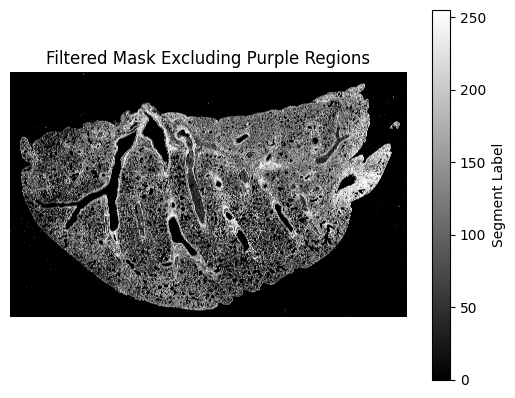

In [37]:
red_threshold_lower = 220  # Example threshold, adjust as needed
blue_threshold_lower = 110  # Example lower threshold for blue region, adjust as needed
blue_threshold_upper = 185  # Example upper threshold for blue region, adjust as needed
mask_combined=img_gray
# Create masks for the regions based on intensity values
# mask_red = cv2.inRange(img_gray, red_threshold_lower, 255)
mask_blue = cv2.inRange(img_gray, blue_threshold_lower, blue_threshold_upper)
red_threshold_lower = 220  # Adjust as needed
# Create masks for the regions based on intensity values
mask_red = cv2.inRange(mask_blue, red_threshold_lower, 255)

# Set the red regions to 0 in the grayscale image
mask_combined[mask_red > 0] = 0

# Ensure black regions are kept as 0
mask_black = cv2.inRange(mask_combined, 0, 0)
mask_combined[mask_black > 0] = 0
# # mask_combined = cv2.bitwise_or(mask_red, mask_blue)
# mask_combined = np.ones_like(img_gray, dtype=np.uint8) * 255  # Start with all white (255)

# # Set the red and blue regions to 0 in the combined mask
# # mask_combined[mask_red > 0] = 0
# mask_combined[mask_blue > 0] = 0

# Plot the filtered mask to visualize
# plt.imshow(mask_combined, cmap='nipy_spectral')
# # Threshold values for purple region
# # purple_threshold_lower = 0  # Adjust as needed
# # purple_threshold_upper = 50  # Adjust as needed
# # mask_combined_inv = cv2.bitwise_not(mask_combined)
# # # Create a mask for the purple region
# # mask_purple = cv2.inRange(img_gray, purple_threshold_lower, purple_threshold_upper)
# mask_combined[mask_red > 0] = 0
# mask_combined[mask_blue > 0] = 0
# # Invert the purple mask to exclude the purple regions
# mask_purple_inv = cv2.bitwise_not(mask_purple)

# # Apply the inverted purple mask to the combined mask
# filtered_mask = cv2.bitwise_and(mask_combined, mask_combined, mask=mask_purple_inv)

# Plot the filtered mask to visualize
plt.imshow(mask_black, cmap='gray')
plt.colorbar(label='Segment Label')
plt.title('Filtered Mask Excluding Purple Regions')
plt.axis('off')
plt.savefig('/ix1/wchen/Zhaochongyue/spatial/mask_airway_vessel_black_06.png', bbox_inches='tight', dpi=300)
plt.show()

In [42]:
def get_img(name):
    if name in ['A1', 'A2', 'A3','A4']:
        img_fold = os.path.join('/ix1/wchen/Zhaochongyue/spatial/Lung/ST/', name,
                                'outs/spatial/full_image.tif')
    elif name=='08_WT_F_S':
        name='08_WT_F-S'
        img_fold = os.path.join('/ix1/wchen/Shiyue/Projects/2023_06_Influ_Mouse_Lung_ST/RawData/Fastq/Alcorn_Visium_FFPE_Images/', name + '.TIF')
    elif name=='09_WT_F_S':
        name='09_WT_F-S'
        img_fold = os.path.join('/ix1/wchen/Shiyue/Projects/2023_06_Influ_Mouse_Lung_ST/RawData/Fastq/Alcorn_Visium_FFPE_Images/', name + '.TIF')
    else:
        img_fold = os.path.join('/ix1/wchen/Shiyue/Projects/2023_06_Influ_Mouse_Lung_ST/RawData/Fastq/Alcorn_Visium_FFPE_Images/', name + '.TIF')
    img_color = cv2.imread(img_fold, cv2.IMREAD_COLOR)
    # print(img_color.shape,'shape')
    img_color = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    # img_color = img_color.astype(np.float32) / 255.0
    # img_color = eval_transforms()(img_color)
    # img_color=img_color.permute(1, 2, 0)
    #print(img_color.shape,'shape1')
    return img_color
# names = ['05_WT_SA_Only','03_WT_SA_Only','01_WT_Naive','08_WT_F_S','07_WT_Flu_Only','02_WT_Naive','09_WT_F_S','06_WT_Flu_Only']
names =['06_WT_Flu_Only']
def calculate_scale_for_divisible_dimensions(original_height, original_width, divisor=256):
    # Calculate the nearest multiple of 256 above the original dimensions
    nearest_multiple_height = divisor * ((original_height + divisor - 1) // divisor)
    nearest_multiple_width = divisor * ((original_width + divisor - 1) // divisor)

    # Calculate scale factors
    scale_height = nearest_multiple_height / original_height
    scale_width = nearest_multiple_width / original_width

    # Choose the smaller scale to ensure both dimensions are reduced
    # to the nearest values divisible by 256 and to avoid unnecessary upsampling
    scale = min(scale_height, scale_width)
    
    return scale
def crop_to_divisible_dimension(img, divisor=256):
    original_height, original_width = img.shape[:2]
    
    # Calculate the amount to crop from each dimension to make them divisible by 256
    crop_height = original_height % divisor
    crop_width = original_width % divisor
    
    # Calculate the top-left corner for cropping to center the crop as much as possible
    top = crop_height // 2
    left = crop_width // 2
    
    # Calculate the new height and width
    new_height = original_height - crop_height
    new_width = original_width - crop_width
    
    # Crop the image
    cropped_img = img[top:top+new_height, left:left+new_width]
    
    # Shift from the original location (top, left) represents how much the top-left corner has moved
    shift = (top, left)
    
    return cropped_img, shift
def generate_fine_patch_positions(coarse_center, fine_patch_size, coarse_patch_size):
    positions = []
    half_coarse_size = coarse_patch_size // 2
    start_x = coarse_center[0] - half_coarse_size
    start_y = coarse_center[1] - half_coarse_size
    num_steps = coarse_patch_size // fine_patch_size
    half_fine_size = fine_patch_size // 2

    for i in range(num_steps):
        for j in range(num_steps):
            fine_center_x = start_x + i * fine_patch_size + half_fine_size
            fine_center_y = start_y + j * fine_patch_size + half_fine_size
            positions.append((fine_center_x, fine_center_y))
    
    return positions
all_image_patches=[]
all_centers_new=[]
all_fine_patch_positions = []
for name in names:
    image = get_img(name)
    image, shift_image = crop_to_divisible_dimension(image)
    
    patches, centers = extract_non_overlapping_patches_from_numpy_with_centers(image, patch_size=256)
    
    all_image_patches.append(patches)
    all_centers_new.append(centers)
    
    fine_patch_positions = []
    for coarse_center in centers:
        fine_positions = generate_fine_patch_positions(coarse_center, fine_patch_size=16, coarse_patch_size=256)
        fine_patch_positions.append(fine_positions)
    
    fine_patch_positions = np.array(fine_patch_positions).reshape(len(centers), 256, 2)
    all_fine_patch_positions.append(fine_patch_positions)
model_reconstruction.eval()  # Ensure the model is in evaluation mode
patch_size = (720, 1168)
centers = []
for i in range(patch_size[0]):
    for j in range(patch_size[1]):
        centers_x = j * 16 + 8
        centers_y = i * 16 + 8
        centers.append((centers_x, centers_y))  
# Assume `large_image_patches` is a tensor of shape (num_patches, C, H, W)
# containing all patches extracted from the large image
# Assume `device` is your computing device ('cuda' or 'cpu')
# Assume `chunk_size` is defined based on your memory 
# Convert lists to tensors
centers_tensor = torch.tensor(centers, dtype=torch.float32)

# Filter the patches based on the boundary mask using indices
filtered_centers = []
filtered_patches = []
# flipped_mask = np.flipud(mask_black)
for index, center in enumerate(centers):
    centers_x, centers_y = center
    # print(inverted_mask[int(centers_y), int(centers_x)])
    if mask_black[int(centers_y), int(centers_x)]:  # Check if the center is within the background
        filtered_centers.append(center)
        filtered_patches.append(image_gene_expression[index])

filtered_centers_tensor = torch.tensor(filtered_centers, dtype=torch.float32)
filtered_patches_tensors = [torch.tensor(patch, dtype=torch.float32) for patch in filtered_patches]
stacked_patches_tensor = torch.stack(filtered_patches_tensors)
# model_reconstruction.vit.image_projection.to('cpu')
# model_reconstruction.vit.image_encoder.to('cpu')
# model_reconstruction.vit.decoder.to('cpu')
# with torch.no_grad():
#     all_image_embeddings = []  # List to store embeddings for each image's patches
#     all_fine_embeddings=[]
#     all_fine_embeddings = model_reconstruction.vit.decoder(model_reconstruction.vit.image_projection(features))
    # # Iterate over each set of patches from the different images
    # for image_patches in all_image_patches:
    #     image_patch_embeddings = []  # Temporarily store embeddings for the current image's patches

    #     # Calculate total patches and the number of chunks needed
    #     total_patches = image_patches.size(0)
    #     num_chunks = (total_patches - 1) // chunk_size + 1  # Ensure covering all patches

    #     for i in range(num_chunks):
    #         # Determine the start and end index of the current chunk
    #         start_idx = i * chunk_size
    #         end_idx = min(start_idx + chunk_size, total_patches)
            
    #         # Extract the current chunk of patches
    #         patch_chunk = image_patches[start_idx:end_idx].to('cpu')
            
    #         # Process the chunk to extract image embeddings
    #         chunk_embeddings = model_reconstruction.vit.decoder(model_reconstruction.vit.image_projection(model_reconstruction.vit.image_encoder(patch_chunk)))
    #         # mean = chunk_embeddings.mean(dim=0, keepdim=True)
    #         # std = chunk_embeddings.std(dim=0, keepdim=True, unbiased=False)
    #         # chunk_embeddings = (chunk_embeddings - mean) / (std + 1e-6)  # Prevent division by zero
    #         # Collect the embeddings for the current chunk
    #         image_patch_embeddings.append(chunk_embeddings.cpu())  # Move to CPU to save GPU memory

    #     # Concatenate all chunks' embeddings for the current image and append to the main list
    #     all_image_embeddings.append(torch.cat(image_patch_embeddings, dim=0)[:,0,:].detach().cpu())
    #     all_fine_embeddings.append(torch.cat(image_patch_embeddings, dim=0)[:,1:,:].detach().cpu())

In [43]:
def get_cnt_min_max(name):
    if name in ['A1', 'A2', 'A3','A4']:
        input_dir = os.path.join('/ix1/wchen/Zhaochongyue/spatial/Lung/ST/', name, 'outs/')
    elif name=='05_WT_SA_Only':
        name='05_WT_SA_Only_2'
        input_dir = os.path.join('/ix1/wchen/Zhaochongyue/spatial/Lung/Lung_new/SpaceRanger_output/', name, 'outs/')
    elif name=='03_WT_SA_Only':
        name='03_WT_SA_Only_2'
        input_dir = os.path.join('/ix1/wchen/Zhaochongyue/spatial/Lung/Lung_new/SpaceRanger_output/', name, 'outs/')
    else:
        input_dir = os.path.join('/ix1/wchen/Zhaochongyue/spatial/Lung/Lung_new/SpaceRanger_output/', name, 'outs/')
    adata = sc.read_visium(path=input_dir, count_file='filtered_feature_bc_matrix.h5')
    adata.var_names_make_unique()
    # print(adata.obsm['spatial'])
    # print("Barcode names (first 5):", adata.obs.index[:5])
    # sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=1000)
    # sc.pp.normalize_total(adata, target_sum=1e4)
    # sc.pp.log1p(adata)
    # adata = adata[:, adata.var['highly_variable']]
    #print(adata,'adata')
    if name in ['A1', 'A2', 'A3','A4']:
        file_Adj = os.path.join(input_dir, "spatial/tissue_positions_list.csv")
    elif name=='05_WT_SA_Only':
        file_Adj = os.path.join(input_dir, "spatial/tissue_positions_list.csv")
    elif name=='03_WT_SA_Only':
        file_Adj = os.path.join(input_dir, "spatial/tissue_positions_list.csv")
    else:
        file_Adj = os.path.join(input_dir, "spatial/tissue_positions_list.csv")
    if name in ['A1', 'A2', 'A3','A4']:
        positions = pd.read_csv(file_Adj, header=None)
        positions.columns = [
                'barcode',
                'in_tissue',
                'array_row',
                'array_col',
                'pxl_row_in_fullres',
                'pxl_col_in_fullres',
        ]
    else:
        positions = pd.read_csv(file_Adj)
    # print(positions.shape)
    positions = positions[positions['in_tissue'] == 1]
    # print(positions.shape)
    # print(positions)
    negative_values = positions[(positions['pxl_row_in_fullres'] < 0) | (positions['pxl_col_in_fullres'] < 0)]
    # if not negative_values.empty:
    #     print("Negative values found in 'pxl_row_in_fullres' or 'pxl_col_in_fullres':")
    #     print(negative_values)
        # Set the index to barcode for merging
    positions.set_index('barcode', inplace=True)
    # positions.set_index('barcode', inplace=True)
    # adata.obs.set_index('barcode', inplace=True)

    # Perform an inner merge to keep only matching rows
    merged_obs = adata.obs.join(positions, how='inner', lsuffix='_adata', rsuffix='_positions')
    adata.obsm['spatial'] = merged_obs[[ 'pxl_row_in_fullres', 'pxl_col_in_fullres']].to_numpy()
    spatial_data = adata.obsm['spatial']
    filter_mask = (spatial_data[:, 0] >= 128) & (spatial_data[:, 1] >= 128)
    filtered_spatial_data = spatial_data[filter_mask]

    # Update adata.obsm['spatial'] with the filtered data
    adata = adata[filter_mask]

    # Update the spatial coordinates in adata.obsm['spatial']
    adata.obsm['spatial'] = filtered_spatial_data
    # print(adata.obsm['spatial'])
    # Prepare the expression data
    expression_data = adata[adata.obs.index].X.todense()
    expression_data = torch.tensor(expression_data)
    min_value=expression_data.min()
    max_value=expression_data.max()
    # Extract the spatial data and gene list
    spatial_data = adata.obsm['spatial']
    has_negative_values = np.any(spatial_data < 0)

    # if has_negative_values:
    #     print("Negative values found in 'spatial' data:")
    #     negative_values = spatial_data[spatial_data < 0]
    #     print(negative_values)
    # else:
    #     print("No negative values found in 'spatial' data.")
    # max_spatial = np.min(spatial_data, axis=0)
    # print(max_spatial)
    gene_list = adata.var_names.tolist()

        # Identify overlapping columns
    # overlap_columns = adata.obs.columns.intersection(positions.columns)

    # # Decide how to resolve conflicts for overlapping columns
    # # Here, we'll keep the column from `positions` and discard the one from `adata.obs`
    # for col in overlap_columns:
    #     adata.obs[col] = positions[col]

    # If there are additional columns in `positions` that are not in `adata.obs`,
    # you might want to merge them into `adata.obs`
    # non_overlap_columns = positions.columns.difference(adata.obs.columns)
    # adata.obs = adata.obs.join(positions[non_overlap_columns], how="left")
    # adata.obs = adata.obs.merge(positions, left_index=True, right_index=True, how='left')
    # adata.obsm['spatial'] = adata.obs[['array_row', 'array_col','pxl_row_in_fullres', 'pxl_col_in_fullres']].to_numpy()
    return min_value,max_value

In [44]:
names =['06_WT_Flu_Only']
all_fine_patch_positions = [torch.tensor(pos) if isinstance(pos, np.ndarray) else pos for pos in all_fine_patch_positions]
embedding_tensor=stacked_patches_tensor
position_tensor=filtered_centers_tensor
# embedding_tensor = torch.cat(all_fine_embeddings, dim=0)
# position_tensor = torch.cat(all_fine_patch_positions, dim=0)
# embedding_tensor = embedding_tensor.view(-1, embedding_tensor.size(2))
# embedding_tensor = embedding_tensor[:, marker_gene_indices]
# Combine dim0 and dim1 for position_tensor
# position_tensor = position_tensor.view(-1, position_tensor.size(2))
# Check the shapes of the resulting tensors
print("Shape of embedding_tensor:", embedding_tensor.shape)
print("Shape of position_tensor:", position_tensor.shape)
min_value,max_value=get_cnt_min_max(names[0])
# embedding_tensor=embedding_tensor * (max_value - min_value+1e-12) + min_value
embedding_tensor = (embedding_tensor - embedding_tensor.min()) / (embedding_tensor.max() - embedding_tensor.min()+1e-12)
# embedding_tensor=embedding_tensor * (max_value - min_value+1e-12) + min_value
adata1 = anndata.AnnData(X=embedding_tensor.numpy())

max_values = embedding_tensor.max(dim=1).values
min_values = embedding_tensor.min(dim=1).values
print("Max values for each point in dim 0 of embedding_tensor:")
print(max_values)

print("Min values for each point in dim 0 of embedding_tensor:")
print(min_values)


# Normalize the data (default behavior scales to 10,000 counts per cell)
# sc.pp.normalize_total(adata1, target_sum=1e4)

# # # # Log1p scale the data
# sc.pp.log1p(adata1)
# embedding_tensor=torch.tensor(adata1.X)

Shape of embedding_tensor: torch.Size([183180, 1000])
Shape of position_tensor: torch.Size([183180, 2])
Max values for each point in dim 0 of embedding_tensor:
tensor([0.1556, 0.1476, 0.1519,  ..., 0.0454, 0.0454, 0.0454])
Min values for each point in dim 0 of embedding_tensor:
tensor([5.9346e-07, 5.3990e-07, 5.6125e-07,  ..., 2.3947e-03, 2.3947e-03,
        2.3947e-03])


In [47]:
# class FinePatchGeneEmbedding(nn.Module): 
#     def __init__(self, in_features, emb_size): 
#         super().__init__() 
#         self.embedding = nn.Linear(in_features, emb_size) 
#     def forward(self, x): 
#         return self.embedding(x) 
class SimpleNN(torch.nn.Module): 
    def __init__(self,input_size): 
        super(SimpleNN, self).__init__() 
        self.fc1 = torch.nn.Linear(input_size, 256) 
        self.relu = torch.nn.ReLU() 
        self.dropout=nn.Dropout(0.3)
        self.fc2 = torch.nn.Linear(256, 28)  # Assuming 9 classes 
    def forward(self, x): 
        x = self.fc1(x) 
        x = self.relu(x) 
        x=self.dropout(x)
        x = self.fc2(x) 
        return x 
class FinePatchGeneEmbedding(nn.Module): 
    def __init__(self, in_channels,patch_size, emb_size): 
        super().__init__() 
        input_dim=in_channels*patch_size*patch_size
        self.embedding = nn.Sequential(nn.Linear(input_dim, 512),
                                       nn.ReLU(),
                                       nn.Linear(512,emb_size)
        )
    def forward(self, x):
        x=x.reshape(x.size(0),-1)
        return self.embedding(x) 
class IndexedAttentionAggregator(nn.Module): 
    def __init__(self, emb_size): 
        super().__init__() 
        self.query_transform = nn.Linear(emb_size, emb_size) 
        self.key = nn.Linear(emb_size, emb_size) 
        self.value = nn.Linear(emb_size, emb_size) 
        self.softmax = nn.Softmax(dim=2) 
    def forward(self, fine_embeddings, coarse_index): 
        unique_indices = coarse_index.unique(sorted=True) 
        valid_indices=[]
        aggregated_embeddings = torch.zeros(len(unique_indices), fine_embeddings.size(-1), device=fine_embeddings.device) 
        for i, idx in enumerate(unique_indices): 
            # mask=(coarse_index == idx)
            # print(fine_embeddings.shape)
            selected_embeddings = fine_embeddings[:,coarse_index == idx]  # Select embeddings for the current coarse index 
            # print(selected_embeddings.shape,'1')
            query = self.query_transform(torch.mean(selected_embeddings, dim=1, keepdim=True)) 
            keys = self.key(selected_embeddings) 
            values = self.value(selected_embeddings) 
            # print(query.shape,keys.shape,values.shape)
            attention_scores = torch.bmm(query, keys.transpose(1, 2)) / torch.sqrt(torch.tensor(keys.size(-1), dtype=torch.float32)) 
            attention_weights = self.softmax(attention_scores) 
            # print(attention_weights.shape,values.shape)
            # output=torch.bmm(attention_weights, values)
            # print(output.shape)
            aggregated_embeddings[i] = torch.bmm(attention_weights, values)
            valid_indices.append(idx.item())
        return aggregated_embeddings,torch.tensor(valid_indices).to(fine_embeddings.device)
class PatchToGeneModel(nn.Module): 
    def __init__(self, in_channels, fine_patch_size, emb_size,device):
        super().__init__() 
        self.fine_patch_gene_embedding = FinePatchGeneEmbedding(in_channels, fine_patch_size, emb_size)
        self.attention_aggregator = IndexedAttentionAggregator(emb_size)
        self.classifier=nn.Linear(384,18)
    def forward(self, fine_patches, coarse_index): 
        batch_size,num_patches, c, h, w = fine_patches.size() 
        fine_patches=fine_patches.view(batch_size*num_patches,c,h,w)
        # print(fine_patches.shape,fine_patches.device,self.fine_patch_gene_embedding,self.attention_aggregator)
        # Transform each fine patch to a gene embedding 
        fine_gene_embeddings =  self.fine_patch_gene_embedding(fine_patches)
        fine_gene_embeddings = fine_gene_embeddings.view(batch_size,num_patches, -1)  # Reshape back to batch format 
        # Aggregate using indexed attention based on coarse patch position 
        aggregated_gene_embeddings,valid_indices = self.attention_aggregator(fine_gene_embeddings, coarse_index) 
        predictions=self.classifier(aggregated_gene_embeddings)
        return aggregated_gene_embeddings, fine_gene_embeddings,valid_indices,predictions  # Return both aggregated and individual fine gene embeddings 
# Example usage 
# device = torch.device("cpu")
# device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# model_fine_gene = PatchToGeneModel(in_channels=3,fine_patch_size=16, emb_size=256,device=device).to(device) 
# fine_patches = torch.rand(200, 256)  # 200 fine patches 
# coarse_index = torch.randint(0, 10, (200,))  # Indices mapping each fine patch to one of 10 coarse patches 
# # predicted_coarse_gene_embeddings, predicted_fine_gene_embeddings = model(fine_patches, coarse_index) 
# # Define the loss function and calculate loss using coarse gene embeddings 
# actual_coarse_gene_embeddings = torch.rand(10, 128)  # Actual coarse gene embeddings 
# criterion = nn.MSELoss() 
# loss = criterion(predicted_coarse_gene_embeddings, actual_coarse_gene_embeddings) 
# print("Loss:", loss.item()) 

In [48]:
from sklearn.neighbors import NearestNeighbors 
import numpy as np 
import torch 
from scipy.sparse import issparse 
# adata_sc=adata_sc[:,marker_genes]
# Assuming adata_sc.X might be a sparse matrix or numpy array 
if issparse(adata_sc.X): 
    adata_tensor = torch.Tensor(adata_sc.X.toarray())  # Convert sparse matrix to dense numpy array, then to tensor 
else: 
    adata_tensor = torch.Tensor(adata_sc.X)  # Direct conversion to tensor if it's already a dense numpy array 
# Check if CUDA is available and move the tensor to GPU if possible 
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
adata_tensor = adata_tensor
# Confirm that the model is also on the same device 
# adata_sc.obsm['X_embedding'] = model.spot_projection(adata_tensor).detach().cpu().numpy(
# Convert PyTorch tensor to NumPy array for compatibility with sklearn 
# model_reconstruction.vit.spot_projection.to(device)
# embeddings=model_reconstruction.vit.spot_projection(adata_tensor).detach().cpu()
# Assuming adata_sc embeddings are already projected and stored 
# mean = embeddings.mean(dim=0, keepdim=True)
# std = embeddings.std(dim=0, keepdim=True, unbiased=False)
# normalized_embeddings = (embeddings - mean) / (std + 1e-6)
# normalized_embeddings=embeddings
# adata_sc.obsm['X_embedding']=normalized_embeddings.numpy()
# adata_sc_embeddings = adata_sc.obsm['X_embedding']
import numpy as np 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score, classification_report 
# Extract embeddings and labels 
# X = adata_sc.obsm['X_embedding'] 
X=adata_tensor
y = adata_sc2.obs['celltype2'].values 
# Encode labels numerically 
label_encoder = LabelEncoder() 
y_encoded = label_encoder.fit_transform(y) 
# Split data into training and validation sets 
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.01, random_state=42) 
import torch 
from torch.utils.data import DataLoader, TensorDataset 
from torch import nn 
from torch.optim import Adam 
# Assuming tensor conversions have already been done, move tensors to the chosen device 
tensor_X_train = torch.tensor(X_train, dtype=torch.float32).to(device) 
tensor_y_train = torch.tensor(y_train, dtype=torch.long).to(device) 
tensor_X_test = torch.tensor(X_test, dtype=torch.float32).to(device) 
tensor_y_test = torch.tensor(y_test, dtype=torch.long).to(device)  

# DataLoaders remain the same 
train_dataset_classi = TensorDataset(tensor_X_train, tensor_y_train) 
train_loader_classi  = DataLoader(train_dataset_classi, batch_size=1024, shuffle=True) 
test_dataset_classi  = TensorDataset(tensor_X_test, tensor_y_test) 
test_loader_classi  = DataLoader(test_dataset_classi, batch_size=1024, shuffle=False) 
# class SimpleNN(torch.nn.Module): 
#     def __init__(self): 
#         super(SimpleNN, self).__init__() 
#         self.fc1 = torch.nn.Linear(X_train.shape[1], 128) 
#         self.relu = torch.nn.ReLU() 
#         self.dropout=nn.Dropout(0.3)
#         self.fc2 = torch.nn.Linear(128, 18)  # Assuming 9 classes 
#     def forward(self, x): 
#         x = self.fc1(x) 
#         x = self.relu(x) 
#         x=self.dropout(x)
#         x = self.fc2(x) 
#         return x 



In [50]:
import torch
from torch.utils.data import DataLoader, TensorDataset
# gene_names = list(adata_sc.var_names)

# # Create a boolean mask for marker genes
# marker_gene_indices = [gene_names.index(gene) for gene in marker_genes if gene in gene_names]
# marker_gene_indices = torch.tensor(marker_gene_indices)

# # Filter the tensor to include only marker genes
# filtered_tensor_data = embedding_tensor[:, marker_gene_indices]
# Assuming you have preprocessed your data into numpy arrays
# Example data shapes:
# N: [num_spots, num_genes] (gene expression levels for each spot)
# spatial_coords: [num_spots, 2] (spatial coordinates for each spot)
# single_cell_data: [num_cells, num_genes] (gene expression levels for each single cell)
# cell_type_labels: [num_cells] (cell type labels for each single cell)
filtered_tensor_data=embedding_tensor
# Convert to PyTorch tensors and transfer to GPU
# N = adata.X.toarray() if isinstance(adata.X, scipy.sparse.csr_matrix) else adata.X  # [num_spots, num_genes]
# spatial_coords = np.array(adata.obsm['spatial'])  # [num_spots, 2]
N_tensor=filtered_tensor_data.to(torch.float32)
spatial_coords_tensor=position_tensor.to(torch.float32)
# N_tensor = torch.tensor(N, dtype=torch.float32)
# spatial_coords_tensor = torch.tensor(spatial_coords, dtype=torch.float32)
# Create the Lambda matrix from single-cell data
# Assuming single_cell_data and cell_type_labels are preprocessed
single_cell_df = pd.DataFrame(X)
single_cell_df['cell_type'] = y_encoded

# Calculate the average gene expression profile for each cell type
Lambda = single_cell_df.groupby('cell_type').mean().values

# Convert Lambda to a PyTorch tensor and transfer to GPU
Lambda_tensor = torch.tensor(Lambda, dtype=torch.float32).cuda()

# Create a dataset and DataLoader for the spot data
spot_dataset = TensorDataset(N_tensor, spatial_coords_tensor)
spot_loader = DataLoader(spot_dataset, batch_size=32, shuffle=False)

# Example shapes
num_genes = N_tensor.shape[1]
num_cell_types = Lambda_tensor.shape[0]
spatial_dim = spatial_coords_tensor.shape[1]


In [51]:
# y = adata_sc2.obs['metacelltype'].values 

# # Encode labels numerically
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y)
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping (Original -> Encoded):")
print(label_mapping)

# Get unique encoded values
unique_encoded_labels = label_encoder.transform(label_encoder.classes_)
print("Unique Encoded Labels:")
print(unique_encoded_labels)

# Get unique original labels
unique_original_labels = label_encoder.classes_
print("Unique Original Labels:")
print(unique_original_labels)

Label Mapping (Original -> Encoded):
{'AT1': 0, 'AT2': 1, 'Alveolar_macrophage': 2, 'B_cell': 3, 'Car4_endothelial_cell': 4, 'Cd274-endothelial-cell': 5, 'Cd4_tcell': 6, 'Cd8_tcell': 7, 'Ciliated_cell': 8, 'Club_cell': 9, 'Endothelial_cell': 10, 'Goblet_cell': 11, 'IgA_plasma_cell': 12, 'Interstitial_macrophage': 13, 'Lymphatic_endothelial_cell': 14, 'Macrophage': 15, 'Mast_cell': 16, 'Matrix_fibroblast': 17, 'Mesothelial_cell': 18, 'Monocyte': 19, 'Myofibroblast': 20, 'NK': 21, 'Neutrophil': 22, 'Pericytes': 23, 'Plasma_cell': 24, 'Vwf_endothelial_cell': 25, 'cDC': 26, 'mitotic-tcell': 27}
Unique Encoded Labels:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]
Unique Original Labels:
['AT1' 'AT2' 'Alveolar_macrophage' 'B_cell' 'Car4_endothelial_cell'
 'Cd274-endothelial-cell' 'Cd4_tcell' 'Cd8_tcell' 'Ciliated_cell'
 'Club_cell' 'Endothelial_cell' 'Goblet_cell' 'IgA_plasma_cell'
 'Interstitial_macrophage' 'Lymphatic_endothelial_cell' 'Macrophage'
 

In [52]:
import torch
import numpy as np
from sklearn.neighbors import NearestNeighbors
from torch_geometric.data import Data
def construct_graph(data, coords, k_neighbors, batch_size):
    num_samples = data.shape[0]
    edge_index = []
    xs = []

    # Use k-d tree for efficient nearest neighbor search
    neighbors = NearestNeighbors(n_neighbors=k_neighbors, algorithm='kd_tree')
    neighbors.fit(coords)
    
    for batch_num, start in enumerate(range(0, num_samples, batch_size)):
        end = min(start + batch_size, num_samples)
        batch_coords = coords[start:end]
        distances, indices = neighbors.kneighbors(batch_coords)
        
        for i in range(len(indices)):
            for j in indices[i]:
                edge_index.append([i + start, j])
        
        x = torch.tensor(data[start:end], dtype=torch.float32)
        xs.append(x)
        
        # Print progress every 1000 batches
        if batch_num % 1000 == 0:
            print(f"Processed {batch_num * batch_size} samples")

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    x = torch.cat(xs, dim=0)
    
    return Data(x=x, edge_index=edge_index)

# # Example usage
# # Assuming N_tensor and spatial_coords_tensor are defined
# data = N_tensor.numpy()
# coords = spatial_coords_tensor.numpy()
# k_neighbors = 10  # Number of nearest neighbors to consider
# batch_size = 1000  # Number of samples to process per batch

# graph_data = construct_graph(data, coords, k_neighbors, batch_size)


In [53]:
from scipy.sparse import coo_matrix
def aggregate_gene_expressions(data):
    x, edge_index = data.x, data.edge_index
    num_nodes = x.size(0)
    
    # Create a sparse adjacency matrix
    values = np.ones(edge_index.size(1))
    indices = np.vstack((edge_index[0].cpu().numpy(), edge_index[1].cpu().numpy()))
    
    i = torch.tensor(indices, dtype=torch.long)
    v = torch.tensor(values, dtype=torch.float32)
    shape = (num_nodes, num_nodes)
    
    adj = torch.sparse_coo_tensor(i, v, shape)
    
    # Perform sum aggregation
    aggregated_expressions = torch.sparse.mm(adj, x)
    
    return aggregated_expressions

# Example usage
# aggregated_expressions = aggregate_gene_expressions(graph_data)
# aggregated_expressions_list = aggregated_expressions.numpy()


In [54]:
import torch

def classify_spots(aggregated_expressions, single_cell_classifier, device):
    single_cell_classifier.to(device)
    single_cell_classifier.eval()
    
    inputs = torch.tensor(aggregated_expressions).to(device)
    with torch.no_grad():
        outputs = single_cell_classifier(inputs)
        # print("Shape of outputs:", outputs.shape)  # Debugging line
        probabilities = torch.softmax(outputs, dim=1)
        predictions = torch.argmax(outputs, dim=1).cpu().numpy()
    return predictions
    # filtered_predictions = []
    # for i, prediction in enumerate(predictions):
    #     if prediction == 6 and probabilities[i, 6].item() >= 0.1:
    #         probability = probabilities[i, 6].item()
    #         # print(f"Prediction is 6 for spot {i} with probability {probability:.4f}")
    #         filtered_predictions.append(prediction)
    #     else:
    #         filtered_predictions.append(26)  # or any placeholder for filtered out predictions

    # return filtered_predictions

# Example usage
# Assuming single_cell_classifier is a pre-trained classifier
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# all_predictions = classify_spots(aggregated_expressions_list, model_classification, device)


In [55]:
from scipy.stats import mode

def determine_most_common_label(all_predictions):
    all_predictions = np.array(all_predictions)
    most_common_labels = mode(all_predictions, axis=0).mode[0]
    return most_common_labels

# Example usage
# most_common_labels = determine_most_common_label(all_predictions)
def prepare_visualization_data(coords, predictions):
    coords = np.array(coords)
    predictions = np.array(predictions)
    
    df = pd.DataFrame({
        'x': coords[:, 0],
        'y': coords[:, 1],
        'prediction': predictions
    })
    
    return df

# Step 6: Visualize Predictions
def visualize_predictions(df):
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=df, x='x', y='y', hue='prediction', palette='viridis', s=10)
    plt.title('Spatial Distribution of Predicted Labels')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend(title='Predicted Label', loc='upper right')
    plt.show()

In [56]:
from scipy.spatial import distance
def select_top_k_informative_cells(single_cell_df, num_clusters=10, top_k=5):
    unique_types = single_cell_df['cell_type'].unique()
    informative_cells = []
    informative_types = []
    
    for cell_type in unique_types:
        type_df = single_cell_df[single_cell_df['cell_type'] == cell_type]
        type_features = type_df.drop(columns=['cell_type']).values
        
        kmeans = KMeans(n_clusters=num_clusters, random_state=0)
        kmeans.fit(type_features)
        
        for i in range(num_clusters):
            cluster_indices = np.where(kmeans.labels_ == i)[0]
            cluster_cells = type_features[cluster_indices]
            centroid = kmeans.cluster_centers_[i]
            
            dists = np.linalg.norm(cluster_cells - centroid, axis=1)
            top_k_indices = cluster_indices[np.argsort(dists)[:top_k]]
            informative_cells.append(type_features[top_k_indices])
            informative_types.extend([cell_type] * len(top_k_indices))
    
    informative_cells = np.vstack(informative_cells)
    informative_types = np.array(informative_types)
    
    print(f"Shape of informative_cells: {informative_cells.shape}")
    print(f"Shape of informative_types: {informative_types.shape}")
    
    return informative_cells, informative_types

def find_nearest_same_type_by_expression(data_features, data_predictions, single_cell_features, single_cell_types):
    nearest_cells = []
    print(f"Shape of data_features: {data_features.shape}")
    print(f"Shape of data_predictions: {data_predictions.shape}")
    print(f"Shape of single_cell_features: {single_cell_features.shape}")
    print(f"Shape of single_cell_types: {single_cell_types.shape}")
    for idx, (spot_features, spot_type) in enumerate(zip(data_features, data_predictions)):
        same_type_cells = single_cell_features[single_cell_types == spot_type]
        
        if same_type_cells.shape[0] == 0:
            nearest_cells.append(None)
            continue
        
        dists = distance.cdist([spot_features], same_type_cells, 'euclidean')
        nearest_cell_idx = np.argmin(dists)
        nearest_cells.append(same_type_cells[nearest_cell_idx])
    
    return nearest_cells

def replace_spot_with_nearest_cell(data_features, nearest_cells):
    for idx, nearest_cell in enumerate(nearest_cells):
        if nearest_cell is not None:
            data_features[idx] = nearest_cell
    return data_features
# # Select top k most informative cells
# reduced_single_cell_features_np, reduced_single_cell_types_np = select_top_k_informative_cells(single_cell_df, num_clusters=10, top_k=5)
# data_features_np = N_tensor.numpy()
# data_predictions_np = np.array(predictions)
# # Find nearest single cell based on reduced single cell data
# nearest_cells = find_nearest_same_type_by_expression(data_features_np, data_predictions_np, reduced_single_cell_features_np, reduced_single_cell_types_np)

# # Replace spot gene expression with the nearest single cell gene expression
# replaced_data_features_np = replace_spot_with_nearest_cell(data_features_np, nearest_cells)


# Find nearest single cell based on reduced single cell data
# nearest_cells = find_nearest_same_type_by_expression(data_features_np, data_predictions_np, reduced_single_cell_features_np, reduced_single_cell_types_np)


In [57]:
# single_cell_df
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from scipy.spatial import distance
from sklearn.neighbors import NearestNeighbors
import networkx as nx
from torch import nn

# Assuming necessary functions classify_spots_with_scales, select_top_k_informative_cells,
# find_nearest_same_type_by_expression, and replace_spot_with_nearest_cell are defined as above
def group_spots_by_type_and_neighbors(spots_df, distance_threshold=50, batch_size=1000):
    """
    Group spots by cell type and spatial proximity.
    
    Parameters:
    - spots_df: DataFrame containing spot coordinates and cell type.
    - distance_threshold: Maximum distance to consider spots as neighbors.
    - batch_size: Number of spots to process in each batch.
    
    Returns:
    - groups: List of lists containing grouped spot indices.
    """
    groups = []  # Initialize an empty list to store the groups of spot indices
    
    for cell_type in spots_df['cell_type'].unique():  # Iterate over each unique cell type
        type_spots = spots_df[spots_df['cell_type'] == cell_type]  # Select spots of the current cell type
        coords = type_spots[['x', 'y']].values  # Extract the coordinates of the selected spots
        indices = type_spots.index.values
        
        if len(coords) == 0:
            continue  # If there are no spots, skip to the next cell type
        
        # Initialize lists to store row and column indices for the sparse adjacency matrix
        row_indices = []
        col_indices = []
        
        # Process the coordinates in batches
        for batch_num, start in enumerate(range(0, len(coords), batch_size)):
            end = min(start + batch_size, len(coords))
            batch_coords = coords[start:end]
            batch_indices = indices[start:end]
            
            # Create a NearestNeighbors model with the specified radius (distance threshold)
            neighbors = NearestNeighbors(radius=distance_threshold, algorithm='kd_tree')
            neighbors.fit(coords)
            
            # Find neighbors within the distance threshold
            distances, neighbors_indices = neighbors.radius_neighbors(batch_coords)
            
            # Create edges for the graph
            for i, neighbors_list in enumerate(neighbors_indices):
                for neighbor in neighbors_list:
                    if neighbor != i + start:  # Exclude self-loops
                        row_indices.append(batch_indices[i])
                        col_indices.append(indices[neighbor])
        
        # Create a sparse adjacency matrix
        data = np.ones(len(row_indices))
        sparse_adj = coo_matrix((data, (row_indices, col_indices)), shape=(len(coords), len(coords)))
        
        # Create a graph from the sparse adjacency matrix
        graph = nx.from_scipy_sparse_matrix(sparse_adj)
        
        # Find connected components (groups of neighboring spots) in the graph
        components = list(nx.connected_components(graph))
        
        for component in components:
            # Store the indices of the spots in each connected component
            groups.append(list(component))
    
    return groups  # Return the list of groups

# def group_spots_by_type_and_neighbors(spots_df, distance_threshold=50):
#     """
#     Group spots by cell type and spatial proximity.
    
#     Parameters:
#     - spots_df: DataFrame containing spot coordinates and cell type.
#     - distance_threshold: Maximum distance to consider spots as neighbors.
    
#     Returns:
#     - groups: List of lists containing grouped spot indices.
#     """
#     groups = []
#     for cell_type in spots_df['cell_type'].unique():
#         type_spots = spots_df[spots_df['cell_type'] == cell_type]
#         coords = type_spots[['x', 'y']].values
        
#         if len(coords) == 0:
#             continue
        
#         # Create a graph where nodes are spots and edges are between neighbors within the distance threshold
#         neighbors = NearestNeighbors(radius=distance_threshold)
#         neighbors.fit(coords)
#         adjacency_matrix = neighbors.radius_neighbors_graph(coords).toarray()
        
#         # Create a graph from the adjacency matrix
#         graph = nx.Graph(adjacency_matrix)
        
#         # Find connected components (groups of neighboring spots)
#         components = list(nx.connected_components(graph))
        
#         for component in components:
#             groups.append(type_spots.index[list(component)].tolist())
    
#     return groups

def identify_cell_centers(spots_df, groups):
    """
    Identify the geometric center of each cell group.
    
    Parameters:
    - spots_df: DataFrame containing spot coordinates and cell type.
    - groups: List of lists containing grouped spot indices.
    
    Returns:
    - centers: List of tuples containing the coordinates of the cell centers.
    """
    centers = []
    for group in groups:
        group_coords = spots_df.loc[group, ['x', 'y']].values
        center = group_coords.mean(axis=0)
        centers.append(center)
    
    return centers

class CrossAttentionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(CrossAttentionModel, self).__init__()
        self.attention = nn.MultiheadAttention(input_dim, num_heads=4, batch_first=True)
        self.fc = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        attn_output, _ = self.attention(x, x, x)
        embedding = self.fc(attn_output.mean(dim=1))
        return embedding

def aggregate_gene_expression(groups, spots_df, model, device):
    """
    Aggregate gene expression for each group using a cross-attention model.
    
    Parameters:
    - groups: List of lists containing grouped spot indices.
    - spots_df: DataFrame containing spot gene expression data.
    - model: Cross-attention model.
    - device: Torch device (CPU or GPU).
    
    Returns:
    - aggregated_expressions: Tensor containing the aggregated gene expressions for each group.
    """
    model.to(device)
    model.eval()
    aggregated_expressions = []
    
    with torch.no_grad():
        for group in groups:
            group_features = spots_df.loc[group, spots_df.columns[:-3]].values  # Exclude 'x', 'y', 'cell_type'
            group_tensor = torch.tensor(group_features, dtype=torch.float32).unsqueeze(0).to(device)
            aggregated_expression = model(group_tensor)
            aggregated_expressions.append(aggregated_expression.squeeze(0).cpu().numpy())
    
    return np.array(aggregated_expressions)
# embeddings now contain the embeddings for the cell centers
# Define the cross-attention model
class CrossAttentionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(CrossAttentionModel, self).__init__()
        self.attention = nn.MultiheadAttention(input_dim, num_heads=4, batch_first=True)
        self.fc = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        attn_output, _ = self.attention(x, x, x)
        embedding = self.fc(attn_output.mean(dim=1))
        return embedding

def train_cross_attention_model(model, train_loader, single_cell_features, single_cell_types, epochs, device):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    model.to(device)
    single_cell_features = torch.tensor(single_cell_features, dtype=torch.float32).to(device)
    single_cell_types = torch.tensor(single_cell_types, dtype=torch.long).to(device)
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        
        for inputs, cell_types in train_loader:
            inputs = inputs.to(device)
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = 0.0
            
            for i, output in enumerate(outputs):
                same_type_mask = single_cell_types == cell_types[i]
                different_type_mask = single_cell_types != cell_types[i]
                
                same_type_features = single_cell_features[same_type_mask]
                different_type_features = single_cell_features[different_type_mask]
                
                intra_loss = F.mse_loss(output, same_type_features.mean(dim=0))
                inter_loss = -F.mse_loss(output, different_type_features.mean(dim=0))
                
                loss += intra_loss + inter_loss
            
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        
        train_loss /= len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}')
def prepare_data_loaders(spots_df, batch_size):
    features = spots_df[spots_df.columns.difference(['x', 'y', 'cell_type'])].values
    cell_types = spots_df['cell_type'].values

    dataset = TensorDataset(torch.tensor(features, dtype=torch.float32), torch.tensor(cell_types, dtype=torch.long))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return loader
# Example usage
# Assuming N_tensor, spatial_coords_tensor, single_cell_df are defined
def find_communities(coords, labels, distance_threshold=50, batch_size=1000):
    """
    Group spots by spatial proximity and cell type based on the classification labels.
    
    Parameters:
    - coords: Array containing spot coordinates.
    - labels: Array containing spot labels.
    - distance_threshold: Maximum distance to consider spots as neighbors.
    - batch_size: Number of spots to process in each batch.
    
    Returns:
    - groups: List of lists containing grouped spot indices.
    """
    groups = []
    num_spots = len(coords)
    
    for label in np.unique(labels):
        label_indices = np.where(labels == label)[0]
        label_coords = coords[label_indices]
        
        # Process the coordinates in batches to reduce memory usage
        for start in range(0, len(label_coords), batch_size):
            end = min(start + batch_size, len(label_coords))
            batch_coords = label_coords[start:end]
            batch_indices = label_indices[start:end]
            
            # Create a NearestNeighbors model with the specified radius (distance threshold)
            neighbors = NearestNeighbors(radius=distance_threshold)
            neighbors.fit(label_coords)
            
            # Find neighbors within the distance threshold
            distances, neighbors_indices = neighbors.radius_neighbors(batch_coords)
            
            # Create edges for the graph
            edges = []
            for i, neighbors_list in enumerate(neighbors_indices):
                for neighbor in neighbors_list:
                    global_neighbor_index = label_indices[neighbor]
                    if global_neighbor_index != batch_indices[i]:  # Exclude self-loops
                        edges.append((batch_indices[i], global_neighbor_index))
            
            # Create a sparse adjacency matrix
            if edges:
                row_indices, col_indices = zip(*edges)
                data = np.ones(len(row_indices))
                sparse_adj = coo_matrix((data, (row_indices, col_indices)), shape=(num_spots, num_spots))
                
                # Create a graph from the sparse adjacency matrix
                graph = nx.from_scipy_sparse_array(sparse_adj)
                
                # Find connected components (groups of neighboring spots)
                components = list(nx.connected_components(graph))
                
                for component in components:
                    group_indices = list(component)
                    groups.append(group_indices)
    
    return groups

def group_spots_by_cell_mask(coords, cell_mask):
    """
    Group spots by cell mask.
    
    Parameters:
    - coords: Array containing spot coordinates.
    - cell_mask: Array containing the cell mask, where each unique value represents a different cell.
    
    Returns:
    - groups: List of lists containing grouped spot indices.
    """
    unique_cells = np.unique(cell_mask)
    groups = []
    
    for cell in unique_cells:
        if cell == 0:  # Skip background
            continue
        group_indices = np.where(cell_mask == cell)[0]
        groups.append(group_indices.tolist())
    
    return groups

# Convert single cell data DataFrame to features and types
single_cell_df = pd.DataFrame(X)
single_cell_df['cell_type'] = y_encoded

# Convert to TensorDataset and DataLoader
spot_dataset = TensorDataset(N_tensor, spatial_coords_tensor)
spot_loader = DataLoader(spot_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")




In [66]:
import sys
import re
import numpy as np
import pandas as pd
import scanpy as sc

# from utils import read_lines, write_lines, load_tsv
# from marker_score import get_marker_score

def adjust_temperature(probs, temperature):
    logits = np.log(probs)
    logits /= temperature
    probs = np.exp(logits)
    probs = probs / probs.sum(-1, keepdims=True)
    return probs

def sample_from_scores(x, temperature=0.05):
    probs_raw = x / x.sum(-1, keepdims=True)
    probs = adjust_temperature(probs_raw, temperature=temperature)
    z = np.random.rand(*probs.shape[:-1], 1)
    threshs = np.cumsum(probs, -1)
    labels = (z > threshs).sum(-1)
    return labels
def get_scores(cell_by_gene_matrix, final_gene_list, marker_file_df):
    df = marker_file_df[['gene', 'label']]
    labels = np.sort(df['label'].unique()).tolist()
    scores = []
    for lab in labels:
        marker_genes = df[df['label'] == lab]['gene'].values
        # Find indices of marker genes in the final_gene_list
        marker_indices = [i for i, gene in enumerate(final_gene_list) if gene in marker_genes]
        if marker_indices:
            # Sum the expression levels of the marker genes for each cell
            marker_scores = cell_by_gene_matrix[:, marker_indices].sum(axis=1)
        else:
            # If no marker genes are found for a label, use zero scores
            marker_scores = np.zeros(cell_by_gene_matrix.shape[0])
        scores.append(marker_scores)
    scores = np.stack(scores, axis=-1)
    return scores, labels

def predict(scores, labels, most_interested_labels, threshold=0.05):
    most_interested_indices = [labels.index(label) for label in most_interested_labels]
    
    # Compute confidence for the most interested cell types
    most_interested_confidence = scores[:, most_interested_indices].max(axis=1)
    most_interested_label_indices = scores[:, most_interested_indices].argmax(axis=1)
    
    # Initial labels with -1 (unclassified)
    predicted_labels = np.full(most_interested_confidence.shape, -1)
    
    # Classify cells as one of the most interested cell types if they exceed the threshold
    predicted_labels[most_interested_confidence >= threshold] = [
        most_interested_indices[label] for label in most_interested_label_indices[most_interested_confidence >= threshold]
    ]
    
    # Mask for cells not classified as one of the most interested cell types
    remaining_mask = predicted_labels == -1
    
    # For remaining cells, classify based on the max score among all cell types
    remaining_scores = scores[remaining_mask]
    if remaining_scores.size > 0:
        remaining_confidence = remaining_scores.max(axis=-1)
        remaining_labels = remaining_scores.argmax(axis=-1)
    
        # Apply threshold to filter out low-confidence predictions for remaining cells
        remaining_labels[remaining_confidence < threshold] = -1
        
        # Assign remaining labels
        predicted_labels[remaining_mask] = remaining_labels
    
    return predicted_labels


threshold=0.2
# def main():
np.random.seed(0)
data = N_tensor.numpy()
coords = spatial_coords_tensor.numpy()
spots_df1 = pd.DataFrame(coords, columns=['x', 'y'])
    # data_file = sys.argv[1]  # Path to numpy data file
    # output_file = sys.argv[2]  # Output file to save cell-by-label matrix
    # threshold = float(sys.argv[3])  # Confidence threshold for labeling

    # Load the numpy data file
    # data = np.load(data_file)
adata_09 = sc.AnnData(X=data)

    # Use final_gene_list and marker_file_data from preparation step
    # global final_gene_list, marker_file_data

    # Filter the AnnData object to include only the final genes
    # adata = adata[:, final_gene_list].copy()
cell_by_gene_matrix = adata_09.X
gene_names = final_gene_list
most_interested_label=['Interstitial_macrophage','Neutrophil','Ciliated_cell','Club_cell','Goblet_cell','Cd4_tcell','Cd8_tcell','AT1','AT2']
scores, labels_names = get_scores(cell_by_gene_matrix, final_gene_list, marker_file_df)

# Predict labels with a threshold
predicted_indices = predict(scores, labels_names, most_interested_label, threshold=threshold)

# Create final prediction labels
predictions = np.array(["unclassified"] * cell_by_gene_matrix.shape[0], dtype=object)
for i, label_index in enumerate(predicted_indices):
    if label_index != -1:
        predictions[i] = labels_names[label_index]

In [103]:
from skimage.measure import label, regionprops
from skimage.segmentation import find_boundaries
from scipy.ndimage import center_of_mass
import scipy
from skimage.measure import regionprops
coords = spatial_coords_tensor.numpy()
def get_cell_boundaries_and_centers(binary_mask):
    """
    Get cell boundaries and centers from a binary segmentation mask.

    Parameters:
    binary_mask (np.ndarray): 2D array where each cell region has a value of 1.

    Returns:
    list: A list of dictionaries containing cell boundaries and centers.
    """
    # Label connected components in the binary mask
    labelled_mask, num_features = label(binary_mask,return_num=True)
    
    # Get cell boundaries and centers
    centers = center_of_mass(binary_mask, labelled_mask, np.arange(1, num_features + 1))
    print('True')
    props = regionprops(labelled_mask)
    
    cell_info = [
        {
            'boundaries': np.column_stack(np.where(find_boundaries((labelled_mask == prop.label), mode='inner'))),
            'center': center
        }
        for prop, center in zip(props, centers)
    ]

    return cell_info
# from scipy.ndimage import label, center_of_mass
import numpy as np
def get_cell_centers(binary_mask):
    """
    Get cell centers from a binary segmentation mask.

    Parameters:
    binary_mask (np.ndarray): 2D array where each cell region has a value of 1.

    Returns:
    np.ndarray: Array of cell centers (row, col) format.
    """
    # Label connected components in the binary mask
    labelled_mask, num_features = label(binary_mask,return_num=True)
    
    # Get cell centers
    centers = center_of_mass(binary_mask, labelled_mask, np.arange(1, num_features + 1))

    return np.array(centers),labelled_mask
# def get_cell_centers(labelled_mask, coords):
#     """
#     Get cell centers from a labelled segmentation mask and filter by coordinates.

#     Parameters:
#     labelled_mask (np.ndarray): 2D array where each cell region has a unique integer label.
#     coords (tuple): A tuple of (min_row, max_row, min_col, max_col) to filter the cell centers.

#     Returns:
#     np.ndarray: Array of filtered cell centers (row, col) format.
#     np.ndarray: Labelled mask with connected components, in the original coordinates.
#     """
#     min_row = int(np.min(coords[:, 0]))
#     max_row = int(np.max(coords[:, 0]))
#     min_col = int(np.min(coords[:, 1]))
#     max_col = int(np.max(coords[:, 1]))

#     # Filter the labelled mask by the provided coordinates
#     filtered_mask = labelled_mask[min_row:max_row + 1, min_col:max_col + 1]

#     # Get the number of unique labels in the filtered region, excluding 0 (background)
#     unique_labels = np.unique(filtered_mask)
#     unique_labels = unique_labels[unique_labels > 0]  # Exclude background (label 0)

#     # Get cell centers for the filtered region
#     centers = center_of_mass(filtered_mask, labels=filtered_mask, index=unique_labels)

#     # Adjust centers to the original coordinate system
#     adjusted_centers = [(center[0] + min_row, center[1] + min_col) for center in centers]

#     # Create a full-size labelled mask and place the filtered labelled mask within it
#     full_labelled_mask = np.zeros_like(labelled_mask, dtype=int)
#     full_labelled_mask[min_row:max_row + 1, min_col:max_col + 1] = filtered_mask

#     return np.array(adjusted_centers), full_labelled_mask

# def get_cell_centers(binary_mask, coords):
#     """
#     Get cell centers from a binary segmentation mask and filter by coordinates.

#     Parameters:
#     binary_mask (np.ndarray): 2D array where each cell region has a value of 1.
#     coords (tuple): A tuple of (min_row, max_row, min_col, max_col) to filter the cell centers.

#     Returns:
#     np.ndarray: Array of filtered cell centers (row, col) format.
#     np.ndarray: Labelled mask with connected components, in the original coordinates.
#     """
#     min_row = int(np.min(coords[:, 0]))
#     max_row = int(np.max(coords[:, 0]))
#     min_col = int(np.min(coords[:, 1]))
#     max_col = int(np.max(coords[:, 1]))


#     # Filter the binary mask by the provided coordinates
#     filtered_mask = binary_mask[min_row:max_row + 1, min_col:max_col + 1]

#     # Label connected components in the filtered binary mask
#     labelled_mask, num_features = label(filtered_mask, return_num=True)
    
#     # Get cell centers
#     centers = center_of_mass(filtered_mask, labelled_mask, np.arange(1, num_features + 1))

#     # Adjust centers to the original coordinate system
#     adjusted_centers = [(center[0] + min_row, center[1] + min_col) for center in centers]

#     # Create a full-size labelled mask and place the filtered labelled mask within it
#     full_labelled_mask = np.zeros_like(binary_mask, dtype=int)
#     full_labelled_mask[min_row:max_row + 1, min_col:max_col + 1] = labelled_mask

#     return np.array(adjusted_centers), full_labelled_mask
import tifffile as tiff
labels_npz_path = '/ix1/wchen/Zhaochongyue/spatial/visium_06.npz'
# Load the saved npz file
cell_data = scipy.sparse.load_npz(labels_npz_path)
labels = cell_data.toarray()
cells_info,labelled_mask = get_cell_centers(labels)
# def get_cell_centers(binary_mask):
#     """
#     Get cell centers from a binary segmentation mask.

#     Parameters:
#     binary_mask (np.ndarray): 2D array where each cell region has a value of 1.

#     Returns:
#     np.ndarray: Array of cell centers (row, col) format.
#     """
#     # Label connected components in the binary mask
#     labelled_mask, num_features = label(binary_mask,return_num=True)
    
#     # Get cell centers
#     centers = center_of_mass(binary_mask, labelled_mask, np.arange(1, num_features + 1))

#     return np.array(centers),labelled_mask
# cells_info,labelled_mask = get_cell_centers(labels)
# def assign_spots_to_cells_new(coords, labelled_mask, cell_centers, bin_size):
#     """
#     Assign spots to cells based on the cell mask region and cell centers.

#     Parameters:
#     coords (np.ndarray): Array of coordinates for the spots.
#     labelled_mask (np.ndarray): 2D array where each cell has a unique integer ID.
#     cell_centers (np.ndarray): Array of cell centers (row, col) format.
#     bin_size (int): Size of the bin to check overlap with the mask.

#     Returns:
#     dict: Dictionary mapping cell indices to their respective spot indices.
#     """
#     spot_to_cell = {i: [] for i in range(len(cell_centers))}

#     for i, center in enumerate(cell_centers):
#         cell_mask = (labelled_mask == (i + 1))
#         cell_coords = np.column_stack(np.where(cell_mask))

#         for j, coord in enumerate(coords):
#             x_center, y_center = coord
#             if any(
#                 (y_center - bin_size // 2 <= y < y_center + bin_size // 2) and
#                 (x_center - bin_size // 2 <= x < x_center + bin_size // 2)
#                 for y, x in cell_coords
#             ):
#                 spot_to_cell[i].append(j)

#     return spot_to_cell
def assign_spots_to_cells_new(coords, labelled_mask, bin_size):
    """
    Assign spots to cells based on the cell mask region.

    Parameters:
    coords (np.ndarray): Array of coordinates for the spots.
    labelled_mask (np.ndarray): 2D array where each cell has a unique integer ID.
    bin_size (int): Size of the bin to check overlap with the mask.

    Returns:
    dict: Dictionary mapping cell indices to their respective spot indices.
    """
    spot_to_cell = {i: [] for i in np.unique(labelled_mask) if i > 0}

    for j, (x_center,y_center) in enumerate(coords):
        x_min = max(0, int(x_center - bin_size // 2))
        x_max = min(labelled_mask.shape[1], int(x_center + bin_size // 2))
        y_min = max(0, int(y_center - bin_size // 2))
        y_max = min(labelled_mask.shape[0], int(y_center + bin_size // 2))
        
        cell_region = labelled_mask[y_min:y_max, x_min:x_max]
        
        # Get the unique cell IDs within this region
        unique_cells = np.unique(cell_region[cell_region > 0])
        
        # Assign the spot to each of the cells it overlaps with
        for cell_id in unique_cells:
            spot_to_cell[cell_id].append(j)
    spot_to_cell = {cell_id: spots for cell_id, spots in spot_to_cell.items() if spots}
    return spot_to_cell
bin_size = 16  # Example bin size
data = N_tensor.numpy()
coords = spatial_coords_tensor.numpy()
spot_to_cell = assign_spots_to_cells_new(coords, labelled_mask, bin_size)
# print(cells_info[0])

In [106]:
def construct_graph_with_distance_threshold(num_nodes, coords, distance_threshold):
    edges = []
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            distance = np.linalg.norm(coords[i] - coords[j])
            if distance < distance_threshold:
                edges.append((i, j))
                edges.append((j, i))
    return edges
from collections import Counter
def build_graph_with_labels_and_threshold(spot_to_cell, coords, data,  distance_threshold):
    cells_data = []
    cell_centers = {}
    unique_labels = sorted(set(predictions))  # Get unique labels and sort them
    print(unique_labels)
    label_counts = Counter(predictions)
    for label in unique_labels:
        print(f"Label: {label}, Count: {label_counts[label]}")
    label_to_num = {label: idx for idx, label in enumerate(unique_labels)}
    num_to_label = {idx: label for label, idx in label_to_num.items()}  # Reverse mapping for reference

    for cell_id, spot_indices in spot_to_cell.items():
        cell_spots = data[spot_indices]
        cell_coords = coords[spot_indices]
        cell_labels = [label_to_num[label] for label in predictions[spot_indices]]  # Convert labels to numeric
        # cell_labels = predictions[spot_indices]
        local_indices = list(range(len(spot_indices)))
        if len(local_indices) == 1:
            edges = [(0, 0)]  # Add a self-loop for a single spot
        else:
            edges = construct_graph_with_distance_threshold(len(local_indices), cell_coords, distance_threshold)
        if len(edges) == 0:
            print(f"No edges constructed for cell {cell_id} with spots {spot_indices}")
        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
        x = torch.tensor(cell_spots, dtype=torch.float)
        y = torch.tensor(cell_labels, dtype=torch.long)
        data_obj = Data(x=x, edge_index=edge_index,y=y)
        data_obj.cell_id = cell_id  # Add cell ID to the data object
        cells_data.append(data_obj)
        
        # Compute and store the cell center
        center_x, center_y = cell_coords.mean(axis=0)
        cell_centers[cell_id] = (center_x, center_y)
    return cells_data, cell_centers,label_to_num, num_to_label
        # cells_data.append(Data(x=x, edge_index=edge_index, y=y))
    # return cells_data
distance_threshold = 100  # Example distance threshold

cells_data,cell_centers,label_to_num, num_to_label = build_graph_with_labels_and_threshold(spot_to_cell, coords, data, distance_threshold)

['AT1', 'AT2', 'B_cell', 'Cd4_tcell', 'Cd8_tcell', 'Ciliated_cell', 'Club_cell', 'Fibroblast', 'Goblet_cell', 'Interstitial_macrophage', 'Macrophage_HD', 'Neutrophil', 'T_cell', 'Vwf_endothelial_cell', 'unclassified']
Label: AT1, Count: 31989
Label: AT2, Count: 11938
Label: B_cell, Count: 4551
Label: Cd4_tcell, Count: 2375
Label: Cd8_tcell, Count: 1778
Label: Ciliated_cell, Count: 20722
Label: Club_cell, Count: 5042
Label: Fibroblast, Count: 9558
Label: Goblet_cell, Count: 16169
Label: Interstitial_macrophage, Count: 16205
Label: Macrophage_HD, Count: 32
Label: Neutrophil, Count: 12033
Label: T_cell, Count: 9035
Label: Vwf_endothelial_cell, Count: 822
Label: unclassified, Count: 40931


In [71]:
# i=0
# for cell_id, spot_indices in spot_to_cell.items():
#     i+=1
# print(i)

80544


In [107]:
import sys
import re
import numpy as np
import pandas as pd
import scanpy as sc

def adjust_temperature(probs, temperature):
    logits = np.log(probs)
    logits /= temperature
    probs = np.exp(logits)
    probs = probs / probs.sum(-1, keepdims=True)
    return probs

def sample_from_scores(x, temperature=0.05):
    probs_raw = x / x.sum(-1, keepdims=True)
    probs = adjust_temperature(probs_raw, temperature=temperature)
    z = np.random.rand(*probs.shape[:-1], 1)
    threshs = np.cumsum(probs, -1)
    labels = (z > threshs).sum(-1)
    return labels

def get_scores(cell_by_gene_matrix, final_gene_list, marker_file_df):
    df = marker_file_df
    df = df[['gene', 'label']]
    labels = np.sort(df['label'].unique()).tolist()
    scores = []
    for lab in labels:
        marker_genes = df[df['label'] == lab]['gene'].values
        # Find indices of marker genes in the final_gene_list
        marker_indices = [i for i, gene in enumerate(final_gene_list) if gene in marker_genes]
        # Sum the expression levels of the marker genes for each cell
        marker_scores = cell_by_gene_matrix[:,marker_indices].sum(axis=1)
        scores.append(marker_scores)
    scores = np.stack(scores, axis=-1)
    return scores, labels

def predict(scores, threshold=0.05, sample=False):
    mask = np.isfinite(scores).all(-1)
    if sample:
        labels = sample_from_scores(scores, temperature=0.05)
    else:
        labels = np.full(mask.shape, -1)
        labels[mask] = scores[mask].argmax(-1)
    # Compute confidence as the maximum score
    confidence = scores.max(-1)
    # Apply threshold to filter out low-confidence predictions
    labels[confidence < threshold] = -1
    return labels

In [108]:
import torch
import torch.nn as nn
from torch_geometric.nn import GATConv
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GATConv
from torch_geometric.data import DataLoader as PyGDataLoader
from torch_geometric.nn import GATConv, global_max_pool
from torch_geometric.nn import GATConv, global_mean_pool
def predict1(scores, labels, most_interested_labels, threshold=0.05):
    most_interested_indices = [labels.index(label) for label in most_interested_labels]
    
    # Compute confidence for the most interested cell types
    most_interested_confidence = scores[:, most_interested_indices].max(axis=1)
    most_interested_label_indices = scores[:, most_interested_indices].argmax(axis=1)
    
    # Initial labels with -1 (unclassified)
    predicted_labels = np.full(most_interested_confidence.shape, -1)
    
    # Classify cells as one of the most interested cell types if they exceed the threshold
    predicted_labels[most_interested_confidence >= threshold] = [
        most_interested_indices[label] for label in most_interested_label_indices[most_interested_confidence >= threshold]
    ]
    
    # Mask for cells not classified as one of the most interested cell types
    remaining_mask = predicted_labels == -1
    
    # For remaining cells, classify based on the max score among all cell types
    remaining_scores = scores[remaining_mask]
    if remaining_scores.size > 0:
        remaining_confidence = remaining_scores.max(axis=-1)
        remaining_labels = remaining_scores.argmax(axis=-1)
    
        # Apply threshold to filter out low-confidence predictions for remaining cells
        remaining_labels[remaining_confidence < threshold] = -1
        
        # Assign remaining labels
        predicted_labels[remaining_mask] = remaining_labels
    
    return predicted_labels
class LabelAwareWeighting(nn.Module):
    def __init__(self, hidden_features, num_labels):
        super(LabelAwareWeighting, self).__init__()
        self.label_embedding = nn.Embedding(num_labels, hidden_features)
        self.fc = nn.Linear(hidden_features * 2, 1)
    
    def forward(self, x, node_labels):
        # Get label embeddings
        label_embeddings = self.label_embedding(node_labels)  # [num_nodes, hidden_features]
        
        # Concatenate node features with their corresponding label embeddings
        x_label_concat = torch.cat([x, label_embeddings], dim=1)  # [num_nodes, hidden_features * 2]
        
        # Compute the weight for each node
        node_weights = torch.sigmoid(self.fc(x_label_concat))  # [num_nodes, 1]
        
        return node_weights

class GraphAttentionModelWithSelectiveLabelHandling(nn.Module):
    def __init__(self, in_features, hidden_features, num_labels, out_features, specific_classes):
        super(GraphAttentionModelWithSelectiveLabelHandling, self).__init__()
        self.conv1 = GATConv(in_features, hidden_features, heads=8, concat=True)
        self.conv2 = GATConv(hidden_features * 8, hidden_features, heads=8, concat=True)
        
        self.fc_node_gene_expression = nn.Linear(hidden_features * 8, out_features)  # Node gene expression
        self.label_aware_weighting = LabelAwareWeighting(hidden_features * 8, num_labels)
        self.specific_classes = torch.tensor(specific_classes)  # Specific classes to check

    def forward(self, x, edge_index, node_labels):
        # Node feature extraction using GAT layers
        self.specific_classes = self.specific_classes.to(node_labels.device)
        x1 = self.conv1(x, edge_index)
        x1 = torch.relu(x1)
        x1 = self.conv2(x1, edge_index)
        x1 = torch.relu(x1)
        
        # Predict gene expression for each node
        node_gene_expression = self.fc_node_gene_expression(x1)  # [num_nodes, out_features]
        
        # Compute label-aware weights for each node
        node_weights = self.label_aware_weighting(x1, node_labels)  # [num_nodes, 1]
        
        # Determine if any of the specific classes are present
        mask = torch.isin(node_labels, self.specific_classes)
        
        if torch.any(mask):
            specific_node_expression = x[mask]
            specific_node_weights = node_weights[mask]
            
            # Find the index of the node with the largest weight
            max_weight_idx = torch.argmax(specific_node_weights, dim=0)
            # max_weight_idx = torch.argmax(specific_node_weights, dim=0)
            # num_specific_nodes = specific_node_expression.shape[0]  # Number of masked nodes
            # random_idx = torch.randint(0, num_specific_nodes, (1,))  # Randomly select an index
    
            # # Use the gene expression of the randomly selected node
            # cell_gene_expression = specific_node_expression[random_idx].squeeze(0)
            # Use the gene expression of the node with the largest weight
            cell_gene_expression = specific_node_expression[max_weight_idx].squeeze(0)
            # print(cell_gene_expression.shape)
            # Use the gene expression of the node with the largest weight
            # cell_gene_expression = specific_node_expression[max_weight_idx]
            # cell_gene_expression=torch.max(specific_node_expression, dim=0).values
            # Determine cell label based on the majority of specific classes
            specific_node_labels = node_labels[mask]
            unique_labels, counts = torch.unique(specific_node_labels, return_counts=True)
            cell_label = unique_labels[torch.argmax(counts)]
        else:
            # General weighted integration for nodes without specific classes
            weighted_node_expression = node_gene_expression * node_weights  # Element-wise multiplication
            cell_gene_expression = torch.sum(weighted_node_expression, dim=0)  # Summing across all nodes
            
            # Assign the cell label based on the majority vote
            unique_labels, counts = torch.unique(node_labels, return_counts=True)
            cell_label = unique_labels[torch.argmax(counts)]
        
        return node_gene_expression, cell_gene_expression, cell_label
num_classes = 28  # example number of cell types
feature_dim = data.shape[1]  # input feature dimension based on the data
hidden_dim = 32  # example hidden feature dimension
output_dim = data.shape[1]  # example gene expression profile dimension
num_epochs = 100  # example number of training epochs
num_clusters=3
# specific_classes=
specific_classes_names = ['Interstitial_macrophage','Neutrophil','Ciliated_cell','Club_cell','Goblet_cell','Cd4_tcell','Cd8_tcell','AT1','AT2']  # Example specific classes
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
specific_classes_nums = [label_to_num[name] for name in specific_classes_names]
model = GraphAttentionModelWithSelectiveLabelHandling(in_features=feature_dim, hidden_features=hidden_dim, num_labels=28,out_features=output_dim, specific_classes=specific_classes_nums)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loader = PyGDataLoader(cells_data, batch_size=2048, shuffle=True)

model = model.to(device)

# # Assume single_cell_data and single_cell_labels are available
# single_cell_data = ...  # single-cell gene expression data
# single_cell_labels = ...  # corresponding single-cell labels

def adjacency_reconstruction_loss(predicted_x, true_edge_index, num_nodes):
    adj_pred = torch.mm(predicted_x, predicted_x.t())
    adj_true = torch.zeros(num_nodes, num_nodes, device=predicted_x.device)
    adj_true[true_edge_index[0], true_edge_index[1]] = 1
    # print(adj_pred.device,adj_true.device)
    loss = nn.MSELoss()(adj_pred, adj_true)
    return loss

def node_gene_expression_loss(predicted_node_expr, true_node_expr):
    loss = nn.MSELoss()(predicted_node_expr, true_node_expr)
    return loss

def node_label_loss(predicted_node_labels, true_node_labels):
    loss = nn.CrossEntropyLoss()(predicted_node_labels, true_node_labels)
    return loss

def cell_gene_expression_loss(predicted_cell_expr, true_cell_expr):
    loss = nn.MSELoss()(predicted_cell_expr, true_cell_expr)
    return loss
best_loss = float('inf')
best_model_path = "/ix1/wchen/Zhaochongyue/spatial/06_best_model.pth"
for epoch in range(num_epochs):
    total_loss=0
    for batch in loader:
        batch = batch.to(device)
        # print(batch.y)
        optimizer.zero_grad()
        # node_gene_expression, cell_gene_expression, hidden_representation,node_label = model(batch.x, batch.edge_index)
        # node_gene_expression, cell_gene_expression, cell_label
        node_gene_expression, cell_gene_expression, cell_label=model(batch.x, batch.edge_index,batch.y)
        # Adjacency reconstruction loss
        # loss_adj_recon = adjacency_reconstruction_loss(hidden_representation, batch.edge_index, batch.x.size(0))
        
        # Node gene expression prediction loss
        # print(node_gene_expression.shape,batch.x.shape)
        loss_node_gene_expr = node_gene_expression_loss(node_gene_expression, batch.x)
        # print(batch.x.shape,batch.y.shape,node_gene_expression.shape,hidden_representation.shape)
        # Node label prediction loss
        # loss_node_label = node_label_loss(node_label_pred, batch.y)
        
        # Cell gene expression prediction loss
        # true_cell_gene_expression = batch.x.mean(dim=0)  # Replace with actual cell gene expression data
        # loss_cell_gene_expr = cell_gene_expression_loss(cell_gene_expression, true_cell_gene_expression)
        
        # Combine losses
        loss = loss_node_gene_expr
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    average_loss = total_loss / len(loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}")
    # Save the best model
    if average_loss < best_loss:
        best_loss = average_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved with loss: {best_loss}")
model.load_state_dict(torch.load(best_model_path))
model.eval()

# Initialize variables
combined_cell_labels_and_centers = {}
threshold = 0.1
all_cell_data = [cell_data.to(device) for cell_data in cells_data]

# Process all cells in one batch
all_node_expressions = []
all_cell_expressions = []
all_cell_ids = []
all_cell_centers = []

for cell_data in all_cell_data:
    node_gene_expression, cell_gene_expression, cell_label = model(cell_data.x, cell_data.edge_index,cell_data.y)
    # cell_gene_expression=model.node_feature_decoder(cell_gene_expression1)
    all_node_expressions.append(node_gene_expression)
    all_cell_expressions.append(cell_gene_expression)
    all_cell_ids.append(cell_data.cell_id)
    all_cell_centers.append(cell_centers[cell_data.cell_id])

# Concatenate all expressions
all_cell_expressions = torch.stack(all_cell_expressions, dim=0).cpu().detach().numpy()

# Reshape if necessary
if all_cell_expressions.ndim == 1:
    all_cell_expressions = all_cell_expressions.reshape(1, -1)
most_interested_label=['Interstitial_macrophage','Neutrophil','Cd4_tcell','Cd8_tcell','AT1','AT2']
# scores, labels_names = get_scores(cell_by_gene_matrix, final_gene_list, marker_file_df)

# Predict labels with a threshold
# predicted_indices = predict(scores, labels_names, most_interested_label, threshold=0.05)
# Get scores and predict labels for all cell gene expressions
all_scores, label_names= get_scores(all_cell_expressions, final_gene_list, marker_file_df)
all_labels = predict1(all_scores, labels_names, most_interested_label, threshold=0.05)
predictions1 = np.array(["unclassified"] * len(all_cell_ids), dtype=object)

# Update predictions based on all_labels
for i, label in enumerate(all_labels):
    if label != -1:
        predictions1[i] = label_names[label]
# Assign labels to cells
for i, cell_id in enumerate(all_cell_ids):
    cell_center = all_cell_centers[i]
    cell_expression = all_cell_expressions[i]  # Get the corresponding gene expression
    
    # Check if all_labels[i] is valid and not empty
    if all_labels[i] != -1:
        cell_label = predictions1[i]
    else:
        cell_label = -1  # Assign a default value if no valid label is found

    combined_cell_labels_and_centers[cell_id] = {
        'label': cell_label,
        'center': cell_center,
        'gene_expression': cell_expression  # Save the gene expression
    }

Epoch 1/100, Loss: 0.0026583895087242126
Best model saved with loss: 0.0026583895087242126
Epoch 2/100, Loss: 0.0017312491574557499
Best model saved with loss: 0.0017312491574557499
Epoch 3/100, Loss: 0.0014792155649047344
Best model saved with loss: 0.0014792155649047344
Epoch 4/100, Loss: 0.001357130246469751
Best model saved with loss: 0.001357130246469751
Epoch 5/100, Loss: 0.0012657050305278973
Best model saved with loss: 0.0012657050305278973
Epoch 6/100, Loss: 0.0012028204393573106
Best model saved with loss: 0.0012028204393573106
Epoch 7/100, Loss: 0.0011566553497686983
Best model saved with loss: 0.0011566553497686983
Epoch 8/100, Loss: 0.0011172366328537464
Best model saved with loss: 0.0011172366328537464
Epoch 9/100, Loss: 0.0010859660571441055
Best model saved with loss: 0.0010859660571441055
Epoch 10/100, Loss: 0.0010596816340694205
Best model saved with loss: 0.0010596816340694205
Epoch 11/100, Loss: 0.0010386310168541968
Best model saved with loss: 0.0010386310168541968

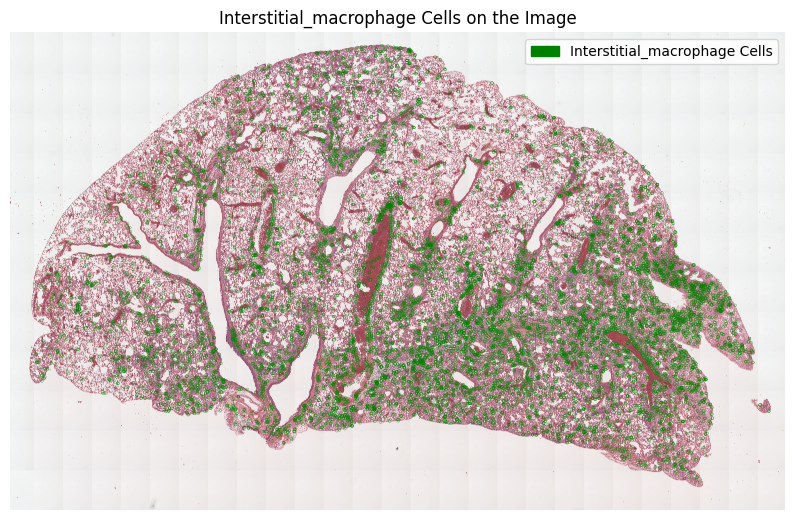

In [117]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from sklearn.preprocessing import LabelEncoder

# Assuming combined_cell_labels_and_centers, image_array, and mask_cleaned are already defined
# Assuming 'adata_sc2' contains the cell type information

# Get the cell type labels and encode them
# y = adata_sc2.obs['celltype2'].values
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y)

# Revert the labels back from the encoded predictions (assuming predictions are available)
# encoded_predictions = label_encoder.inverse_transform(predictions)  # Uncomment if predictions are used

# Convert coordinates and labels into arr ays
coordinates = []
labels = []
for cell_id, info in combined_cell_labels_and_centers.items():
    coordinates.append(info['center'])
    labels.append(info['label'])

coordinates = np.array(coordinates)
labels = np.array(labels)

# Revert the numerical labels back to original string labels
# original_labels = label_encoder.inverse_transform(labels)

# Plotting the image and the filtered coordinates
plt.figure(figsize=(10, 10))
rotated_image = np.flipud(image)
plt.imshow(image / 255,origin='lower')  # Convert BGR to RGB for plotting
ax = plt.gca()

# Plot all cells but highlight the target label (e.g., CD4)
target_label = 'Interstitial_macrophage'
# 'Interstitial_macrophage','Neutrophil','Ciliated_cell','Club_cell','Goblet_cell','Cd4_tcell','Cd8_tcell','AT1','AT2'
#Interstitial_macrophage, Matrix_fibroblast', 'Vwf_endothelial_cell'
color = 'green'  # Define color for CD4
# flipped_mask = np.flipud(mask_combined_inv)
# for i, coord in enumerate(coordinates):
#     if labels[i] == target_label and mask_combined_inv[int(coord[1]),int(coord[0])]>0:
#         circle = patches.Circle((coord[0], coord[1]), radius=10, edgecolor=color, facecolor='none', linewidth=2)
#         ax.add_patch(circle)
for i, coord in enumerate(coordinates):
    if labels[i] == target_label:
        circle = patches.Circle((coord[0], coord[1]), radius=3, edgecolor=color, facecolor='none', linewidth=2)
        ax.add_patch(circle)
# Creating a legend
legend_patches = [patches.Patch(color=color, label=f'{target_label} Cells')]
plt.legend(handles=legend_patches, loc='upper right')

plt.xlabel('Pixel Column in Full Resolution')
plt.ylabel('Pixel Row in Full Resolution')
plt.title(f'{target_label} Cells on the Image')
plt.axis('off')
plt.savefig(f'/ix1/wchen/Zhaochongyue/spatial/{target_label}_cells_image_visium_06.png', bbox_inches='tight', dpi=600)
plt.show()
# plt.figure(figsize=(10, 10))
# plt.imshow(mask_combined_inv, cmap='gray')
# plt.title('Mask')
# plt.axis('off')
# plt.show()